>># **Final Project - Document Corner Detection out of ICDAR 2015 Dataset**

>>Shahaf Yamin ID: 311530943.

>>Yoel Bokobza ID: 312190481.

# Introduction

Documents exist in both paper and digital form in our everyday life. Paper documents are easier to carry, read, and share whereas digital documents are easier to search, index, and store. For efficient knowledge management, it is often required to convert a paper document to digital format. 

Document segmentation from the background is one of the major challenges of digitization from a natural image. An image of a document often contains the surface on which the document was placed to take the picture. It can also contain other non-document objects in the frame. Precise localization of document, often called document segmentation, from such an image is an essential first step required for digitization. Some of the challenges involved in localization are variations in document and background types, perspective distortions, shadows, and other objects in the image.

# Dataset

’ICDAR 2015 SmartDoc Challenge 1’ dataset is used for training and testing. The dataset contains 150 videos. Each video is around 10 seconds long and contains one of the six types of documents placed on one of the five distinct backgrounds. We split these videos into two disjoint sets.
Ground truth is available in the form of (x,y) coordinates labels:
top left (tl), top right (tr), bottom right (br), and bottom left (bl).

The short videos are taken over 5 different backgrounds, where background 5 is relatively complex as will be shown later.
Over each background, the videos have been taken over different document types - datasheet, letter, magazine, paper, patent, and tax, (5 short videos per background and document type).

As an initial pre-process, we replaced each video with its frames (resolution of 1920X1080).
The following images are random frames taken from different videos:




##Background 01 - Datasheet Document
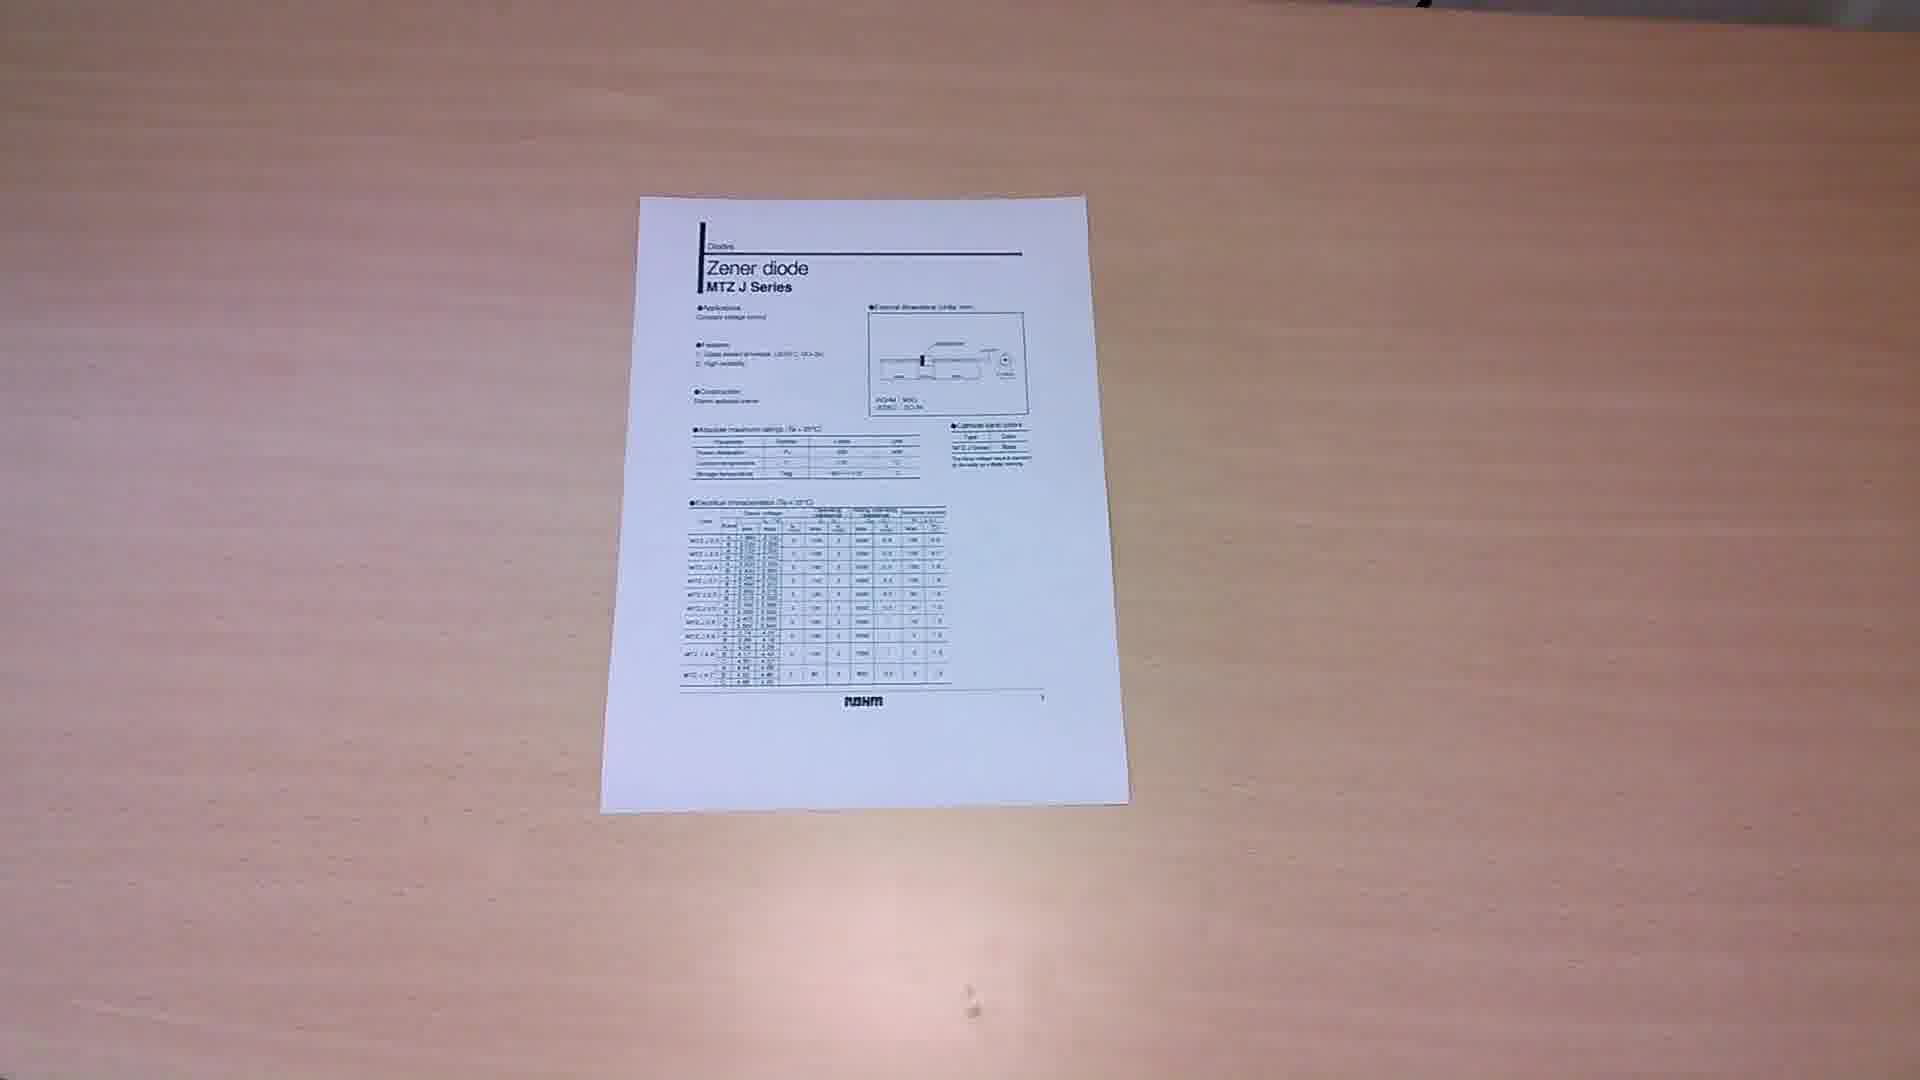



## Background 02 - Magazine Document
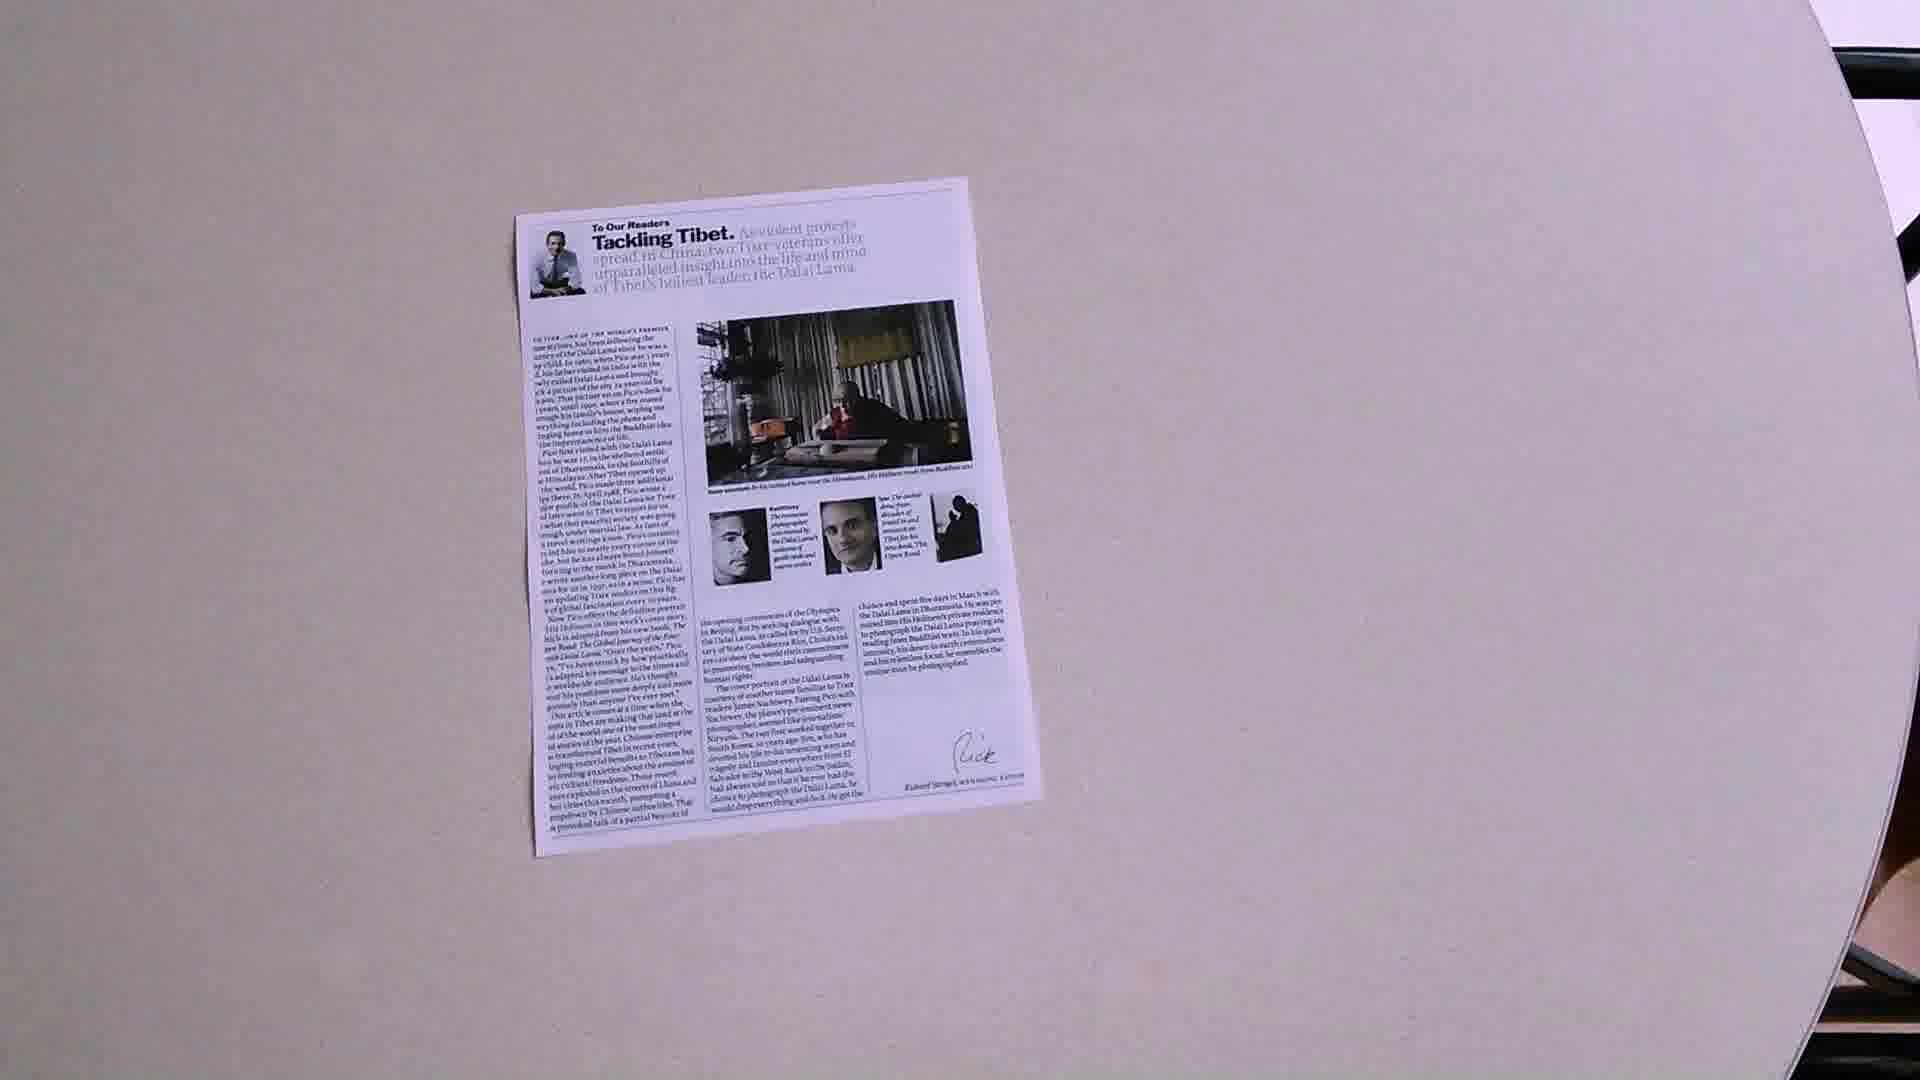


## Background 03 - Patent Document
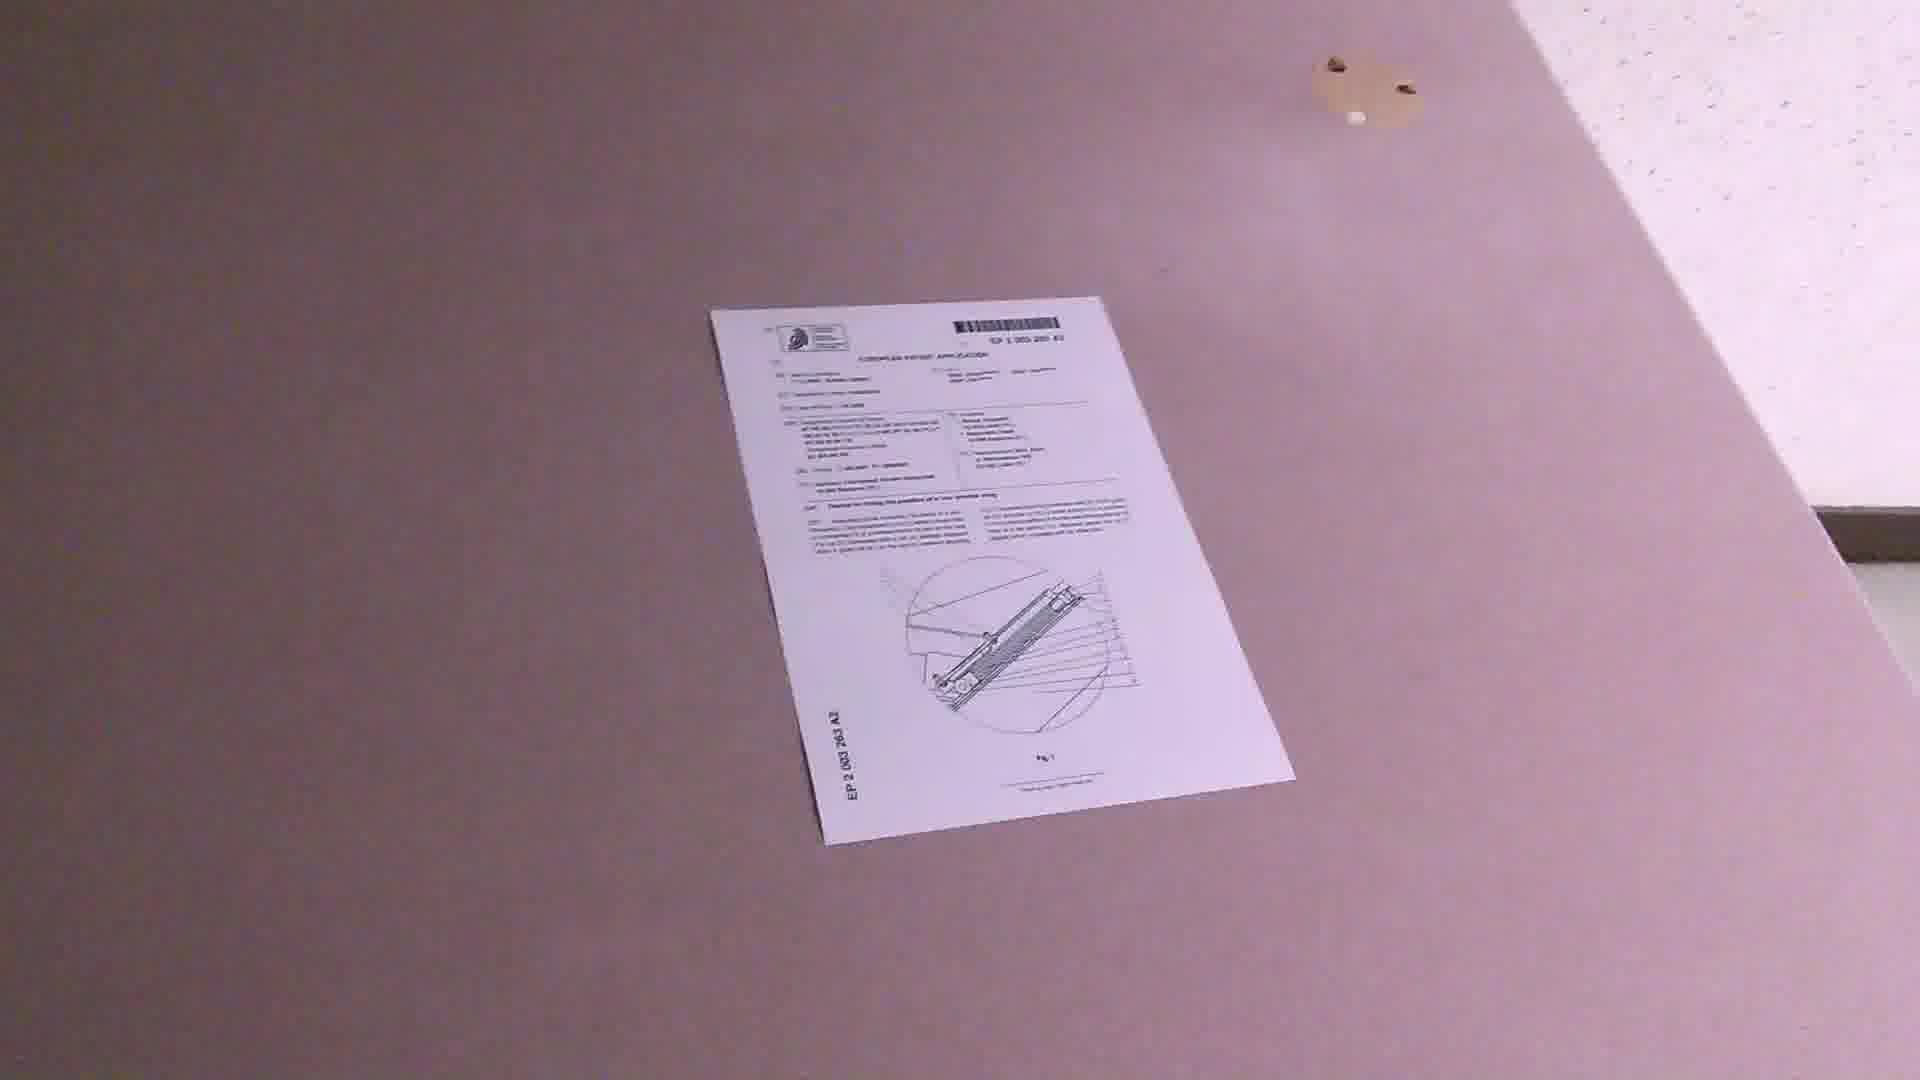


## Background 04 - Letter Document
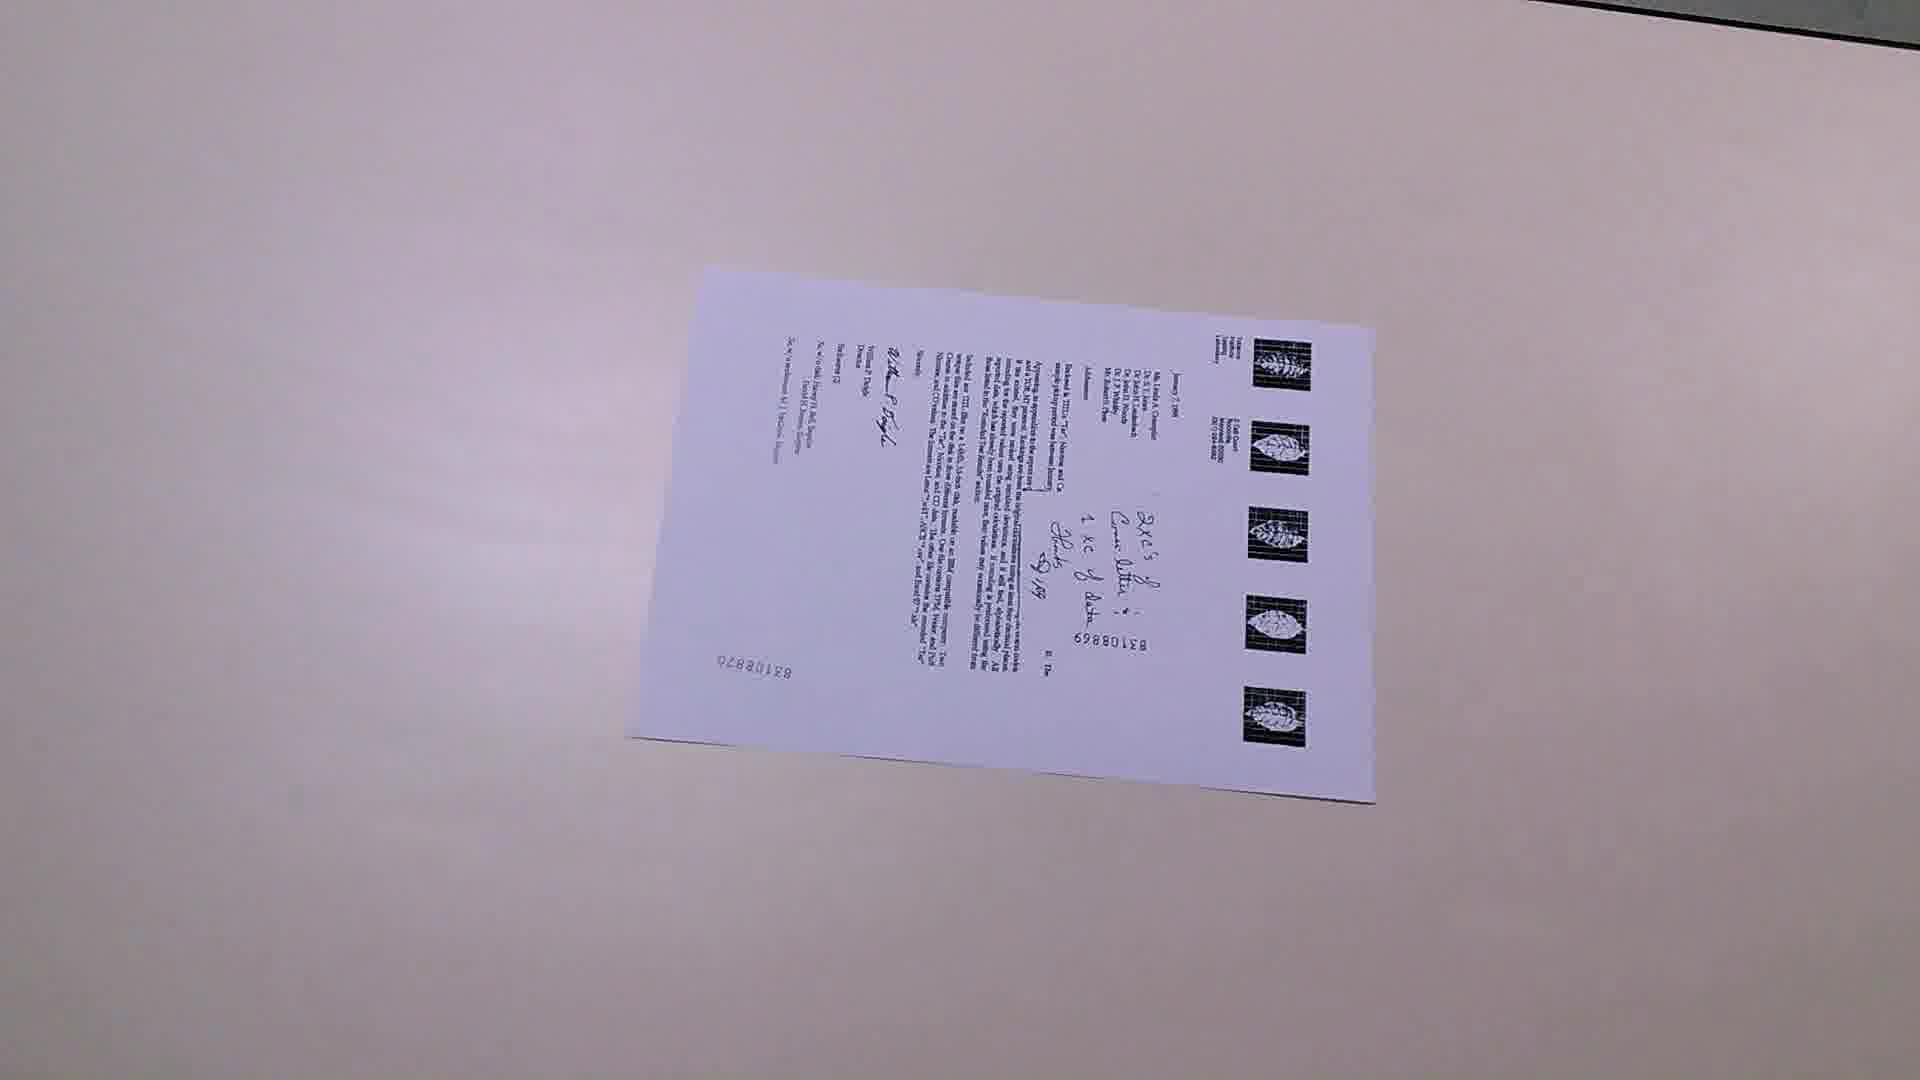

## Background 05 - Paper Document 
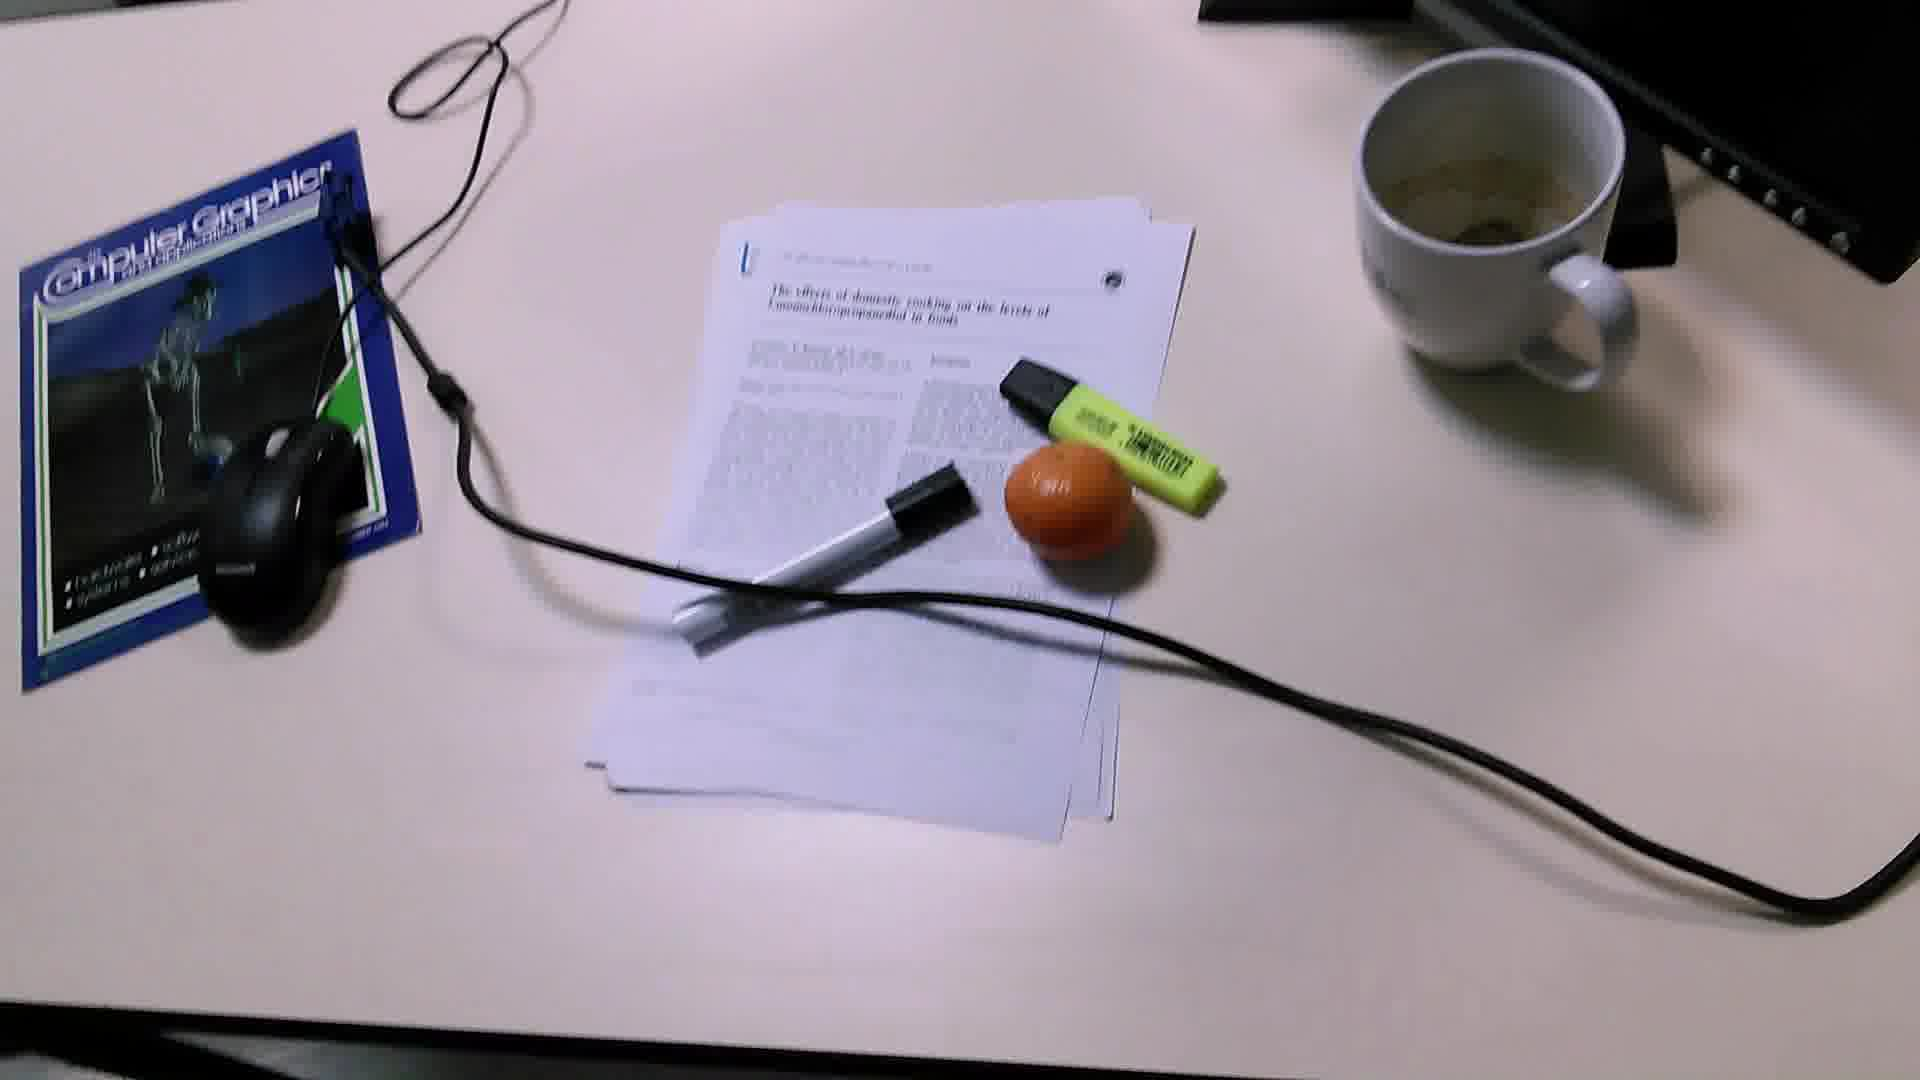

# Our Goal

The goal is to design an algorithm that gets as input an image of the document and predicts the tl, tr, bl, br coordinates of the document.

It is expected that the algorithm will run in a reasonable time (a few seconds).

#Limitations

*  A batch of images with a high resolution (1920x1080) requires a substantial amount of RAM, making them difficult to use as inputs for neural networks on a standard GPU server. We addresed this problem by applying the following paradigm: Applying a 512x512 resize, results in a reduction in computational complexity. 
In addition, we've run our experiments on GPU servers with more available RAM and computing power to accelerate the training procedure.
*   The data set is large. Hence, it is computationally hard to use even 50 percent of the data for training. Therefore, we sampled randomly 50 frames from each video (except for the tax document videos) for the training.
* Reducing the dataset size by randomly sampling frames from each video and shuffling the sampled dataset, also addresses the issue that consecutive frames from each video are highly correlated which violates the i.i.d assumption of the dataset.
* Frames from background 05 are relatively complex compared with the other backgrounds because it contains other objects in the frame placed near or on top of the document.
* The Dataset used to train the benchmark (from the Git) does not contain a validation set. (Only training and test)



#Proposed Algorithm - V1

## High Level Description

We can divide this proposed algorithm into 4 main units:

### Preprocess
1.   Split the data into train, and test
2.   Resize the images to 512X512
3.   Normalize the dataset according to the train set mean and standard deviation.
4.   Apply a Gaussian filter over the images.

### Document Segmentation
Using the well-known deep learning architecture U-Net [1] to create a binary mask segmentation of the document.

### Extracting Corners
The following steps details the algorithm we've developed to extract the 4 corners estimation coordinates from the masked image:
1. Extract edges from the masked image
2.   Apply Hough transform [2] over the edged masked image and extract some predefined number of peaks.
3.   Apply a hand-crafted clustering method to find an estimation of the 4 lines constructing the quadrilateral shape of the masked image
4. Extract corners from the lines equations

### Corners Estimation Refiner
We utilized the edged masked image to further improve the corners estimation.



## Block Diagram

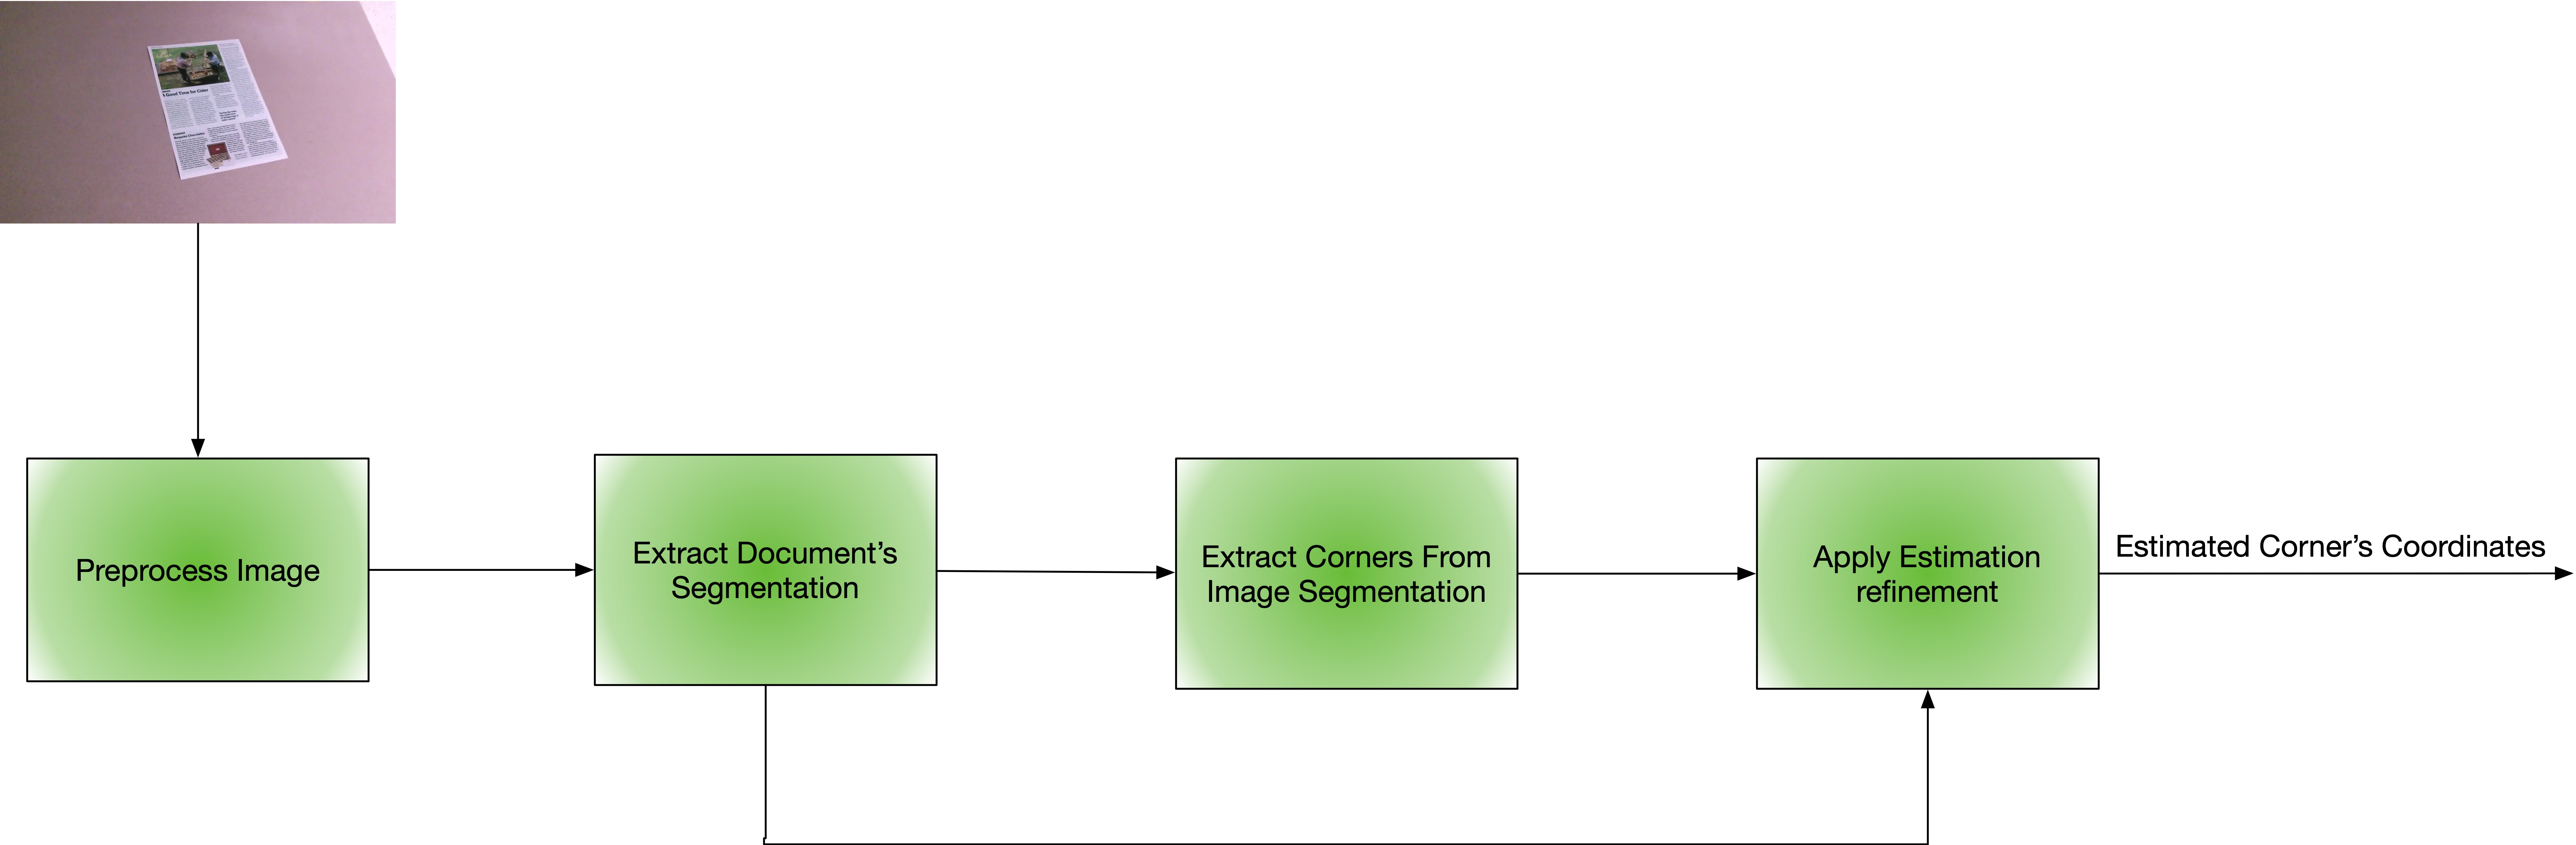

Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


**Before Running the following blocks, please copy the shared folder "DeepLearningProject" into your "MyDrive", or just create a shortcut, by right-clicking on the shared folder and then, "create a shortcut in Drive")**

## Import Libraries

In [2]:
import os                                   
from os.path import abspath
from PIL import Image                        
import PIL.Image as Image
from skimage import transform
import torch  
torch.manual_seed(0)
import torch.optim as optim            
import torch.nn as nn                        
import torch.nn.functional as F          
from torch.utils.data import Dataset      
from torch.utils.data import DataLoader
import numpy as np   
np.random.seed(0)                       
import random
random.seed(10)
import cv2          
import xml.etree.ElementTree as ET                         
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage, GaussianBlur, Compose
import torchvision.transforms.functional as TF
from tqdm import tqdm                         
import matplotlib.pyplot as plt                 
from matplotlib.path import Path
from torch import Tensor
from torch.nn import init
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import math
from copy import deepcopy
import numbers

device = torch.device('cpu')

## Preprocess

### Utils for Data Prepration
The following code block contains utils for our data preprocessing procedure.

In [3]:
def sort_predication(masks_pred):
    """
    The following function receives our corner estimation and sort it according to a predefined sequence
    [Top Left, Top Right, Bottom Right, Bottom Left]
    """
    sort_idx = np.argsort(masks_pred[:, 0])
    tl_idx = np.argmin(masks_pred[sort_idx][:2][:, 1])
    tr_idx = np.argmax(masks_pred[sort_idx][:2][:, 1])
    tl = masks_pred[sort_idx][:2][tl_idx]
    tr = masks_pred[sort_idx][:2][tr_idx]
    bl_idx = np.argmin(masks_pred[sort_idx][2:][:, 1])
    br_idx = np.argmax(masks_pred[sort_idx][2:][:, 1])
    bl = masks_pred[sort_idx][2:][bl_idx]
    br = masks_pred[sort_idx][2:][br_idx]
    return np.array([tl, tr, br, bl])

def gen_mask(coordinates, sizeX, sizeY, sort):
    '''
    The following function generates a binary mask image given 4 2-dimensional coordinates.
    '''


    nx, ny = sizeX, sizeY
    if sort:
        coordinates = sort_predication(coordinates)
        coordinates = list(map(tuple, coordinates))

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    coordinates.append((0., 0.))
    poly_verts = coordinates
    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    y, x = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x, y)).T

    path = Path(poly_verts, codes=codes)
    grid = path.contains_points(points)
    mask = grid.reshape((ny, nx)).T
    return mask

def sort_gt(gt):
    '''
    Sort the ground truth labels so that TL corresponds to the label with smallest distance from O
    :param gt:
    :return: sorted gt
    '''
    myGtTemp = gt * gt
    sum_array = myGtTemp.sum(axis=1)
    tl_index = np.argmin(sum_array)
    tl = gt[tl_index]
    tr = gt[(tl_index + 1) % 4]
    br = gt[(tl_index + 2) % 4]
    bl = gt[(tl_index + 3) % 4]

    return np.asarray((tl, tr, br, bl))


### Load the data and organize it
The following classes load the raw data and organize it.
It also generates the ground truth binary masks from the corresponded ground truth corners. In addition, it is able to calculate first and second-order statistical moments from a given dataset in order to normalize the data.


In [4]:
class _Dataset():
    '''
    Base class to reprenent a Dataset
    '''
    def __init__(self, name):
        self.name = name
        self.data = []
        self.labels = []

class SmartDocDirectories(_Dataset):
    '''
    Class to include SmartDoc Dataset via full resolution images while sampling only 2 images from a single video
    '''

    def __init__(self, frames_per_video, directory="data"):
        super().__init__("smartdoc")
        self.data = []
        self.labels = []

        for folder in os.listdir(directory):
            if (os.path.isdir(directory + "/" + folder)):
                if os.path.isdir(directory+"/"+folder+"/"+os.listdir(directory + "/" + folder)[0]):
                    for file in os.listdir(directory + "/" + folder):
                        images_dir = directory + "/" + folder + "/" + file
                        self.read_background(images_dir,frames_per_video, file=file)                
                else:
                    images_dir = directory + "/" + folder
                    self.read_background(images_dir, frames_per_video, file=folder)


        self.labels = np.array(self.labels)

        self.labels = np.reshape(self.labels, (-1, 8))
        print("Ground Truth Shape: %s", str(self.labels.shape))
        print("Data shape %s", str(len(self.data)))

        self.myData = []
        for a in range(len(self.data)):
            self.myData.append([self.data[a], self.labels[a]])

    def read_background(self, images_dir, frames_per_video, file):

        if (os.path.isdir(images_dir)):
          list_gt = []
          tree = ET.parse(images_dir + "/" + file + ".gt")
          root = tree.getroot()
          for a in root.iter("frame"):
              list_gt.append(a)

          im_no = 0
          # List all available images in a list
          images_list = os.listdir(images_dir)
          # Remove from the list the Ground True
          images_list.remove(file + ".gt")
          
          if frames_per_video == 'all':
            ChosenImages = list(images_list)
          else:
            ChosenImages = list(np.random.choice(images_list, size=frames_per_video))
          for image in ChosenImages:
              im_no += 1
              # Now we have opened the file and GT. Write code to create multiple files and scale gt
              list_of_points = {}

              self.data.append(os.path.join(images_dir, image))
              imageIndex = int(float(image[0:-4])) - 1
              for point in list_gt[imageIndex].iter("point"):
                  myDict = point.attrib

                  list_of_points[myDict["name"]] = (int(float(myDict['x'])), int(float(myDict['y'])))

              ground_truth = np.asarray((list_of_points["tl"], list_of_points["tr"], list_of_points["br"], list_of_points["bl"]))
              ground_truth = sort_gt(ground_truth)
              self.labels.append(ground_truth)


def generate_full_resolution_partial_dataset(path,frames_per_video, size):
    '''
    This function generate a dataset from a given path of images and sample a predefined number of random frames from each video.
    Our dataset contain 3 main objects.
    - Raw RGB Images.
    - Ground Truth Binary Masks.
    - Ground Truth Corners Coordinates.
    It also calculates the first and second statisticals moments of the given dataset.
    '''
    dataset = SmartDocDirectories(directory=path, frames_per_video=frames_per_video)
    images = []
    labels = []
    masks = []
    X_Indices = [0, 2, 4, 6]
    Y_Indices = [1, 3, 5, 7]
    for img_path, label in tqdm(dataset.myData):
        img = Image.open(img_path)
        old_size = img.size
        x_cords = label[X_Indices] * (size / old_size[0])
        y_cords = label[Y_Indices] * (size / old_size[1])
        img = img.resize((size, size))
        img = np.array(img)
        currLabel = [(i, j) for i, j in zip(x_cords, y_cords)]
        normLabel = [(float(x) /old_size[0], float(y)/old_size[1]) for x,y in zip(label[X_Indices],label[Y_Indices])]
        normLabel = list(sum(normLabel,()))
        mask = gen_mask(currLabel, sizeX=img.shape[0], sizeY=img.shape[1], sort=False)
        labels.append(normLabel)
        images.append(img.T)
        masks.append(mask.T)
    stats = {'mean': np.mean(np.array(images)), 'std': np.std(np.array(images))}

    return images, masks, labels, stats



The following code block contains our transformation functions. Which we present in the following list items:
* Resize
* Normalize 
* Gaussian Blurring
* Random Crop Around a Random Corner

In [5]:
class Resize(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = Image.fromarray(img.T.astype('uint8'), 'RGB')
        mask = Image.fromarray(mask.T.astype('uint8'))

        corners = np.array(list(map(lambda x: np.array((x[0] * self.size[0] / img.size[0], x[1] * self.size[1] / img.size[1])), corners)))

        resized_img = img.resize(self.size)
        resized_mask = mask.resize(self.size)

        return np.array(resized_img).T, np.array(resized_mask).T, corners


class Normalize(object):
    def __init__(self, *args):
        self.mean, self.std = tuple(*args)

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = (img - self.mean) / self.std

        return img, mask, corners


class ourGaussianBlur(object):
    def __init__(self, size):
        self.filter = GaussianBlur(size)

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = Image.fromarray(img.T.astype('uint8'), 'RGB')
        img = np.array(self.filter(img)).T

        return img, mask, corners

class RandomCropNearCorner(object):
    '''
    This class conatins our transformation for random crop around a random document's corner.
    We shall notice that this transformation is used only for the training paradigm
    '''
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = Image.fromarray(img.T.astype('uint8'), 'RGB')
        mask = Image.fromarray(mask.T.astype('uint8'))
        w, h = img.size
        th, tw = self.size

        if w == tw and h == th:
            return img
        corner = random.randint(0, 3)
        x_center = corners[(corner*2)] * w
        y_center = corners[(corner*2)+1] * h
        randTw = random.randint(0, tw)
        randTh = random.randint(0, th)
        x1 = max(x_center - randTw, 0)
        y1 = max(y_center - randTh, 0)
        x2 = min(x1 + tw, w)
        y2 = min(y1 + th, h)
        if x2 == w:
            x1 = w - tw
        if y2 == h:
            y1 = h - th
        cropped_img = np.array(img.crop((x1, y1, x2, y2))).T
        cropped_mask = np.array(mask.crop((x1, y1, x2, y2))).T
        new_cor = [(corners[(corner*2)] * w - x1) / tw, (corners[(corner*2)+1] * h - y1) / th]

        return cropped_img, cropped_mask, new_cor



TransformsMapping = {'Resize': Resize, 'GaussianBlur': ourGaussianBlur, 'Normalize': Normalize, 'RandomCropNearCorner': RandomCropNearCorner}



In [6]:
class DocumentDatasetMaskSegmentation(object):
    '''
    This is our dataset implementation for our custom case of 3 different objects for each image (RGB Image, Mask, Coordinates)
    '''
    def __init__(self, Path: str, frames_per_video, Transforms: dict, Size : int):
        self.images, self.masks, self.labels, self.stats = generate_full_resolution_partial_dataset(Path, frames_per_video, size=Size)
        self.withTransforms = len(Transforms) != 0
        if Transforms['Normalize'] is None:
            Transforms['Normalize'] = (self.stats['mean'], self.stats['std'])
        transform_list = [TransformsMapping[transform](value) for transform, value in Transforms.items()]
        self.transforms = Compose(transform_list)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.withTransforms:
            image, mask, label = self.transforms((self.images[idx], self.masks[idx], self.labels[idx]))
        else:
            image, mask, label = self.images[idx], self.masks[idx], self.labels[idx]
        return {
            'image': torch.as_tensor(image).float().contiguous(),
            'mask': torch.as_tensor(mask).long().contiguous(),
            'label': torch.as_tensor(label.copy()).float().contiguous()
        }

Generating the Datasets:

As the dataset is large in this platform we load only a single sample from each video.

(When we trained the model in an out-source server we used the whole dataset)

In [7]:
FILTER_SIZE = 5 #Gaussian Filter
SIZE = 512 #image size 512X512
FRAMES_PER_VIDEO = 1 # Single Sample from each video
mini_train_set = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Train", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': None}, Size=SIZE)
test_set_bg_1 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background01", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_2 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background02", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_3 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background03", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_4 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background04", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_5 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background05", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)


Ground Truth Shape: %s (100, 8)
Data shape %s 100


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


## Image Segmentation - U-Net Architecture


### Network 
U-Net is a commonly used architecture for semantic segmentation. It consists of a contracting path and an expansive path. 

The contracting path follows the typical architecture of a convolutional network. Our architecture consists of Conv-Blocks of two 3x3  2D convolutions, each followed by a batch normalization layer and a rectified linear unit (ReLU). The output of each Conv-Block is inserted into a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step, we double the number of feature channels, except for the first downsampling layer where the number of channels increased from 3 to 64. 


Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 up-convolution that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and a Conv-Block. 
At the final layer, a 1x1 convolution is used to map each 64-component feature vector to a 2D prediction map. each pixel represents the probability that it belongs to the document.

### Unet Arcitecture Diagram

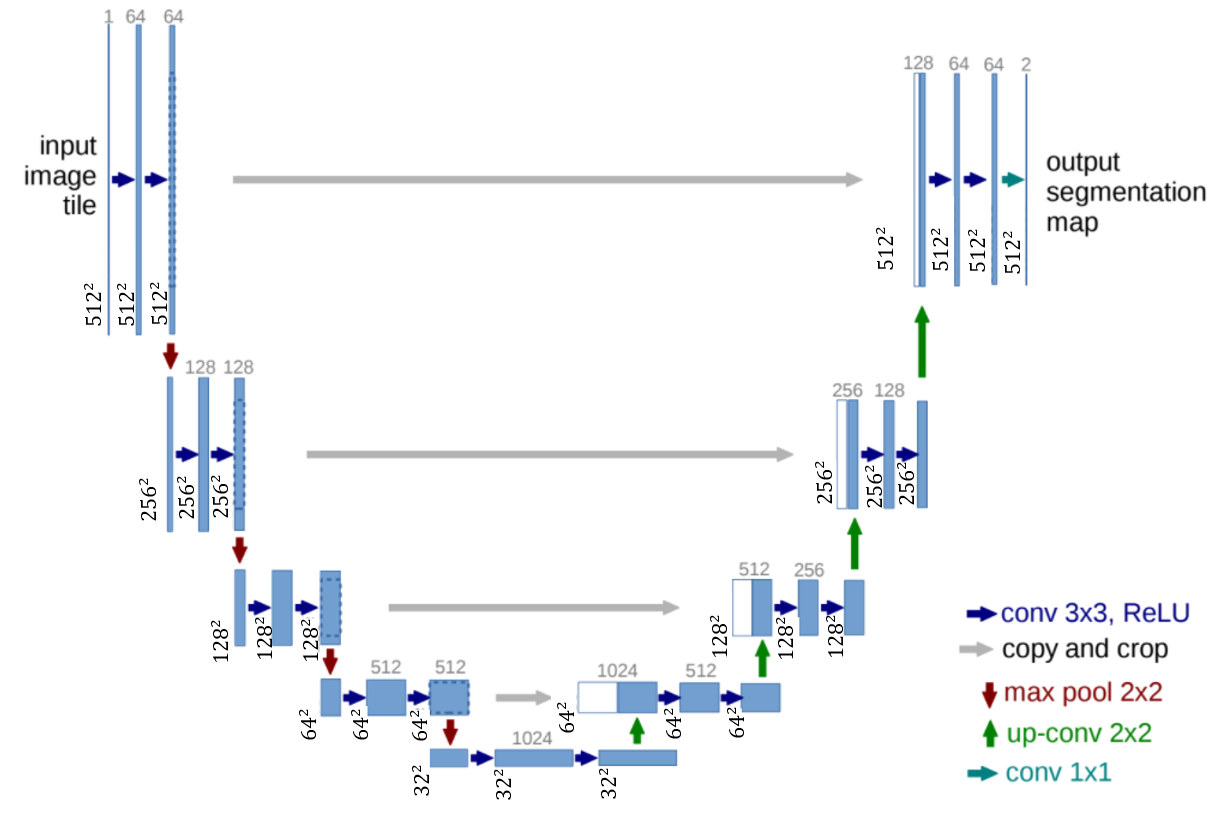

The following code blocks contain our U-net implementation in Pytorch

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [9]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


### Loss Functions:



### **Dice Score**:
Let $X,Y \in \{0,1\}^{N\times M}$ represent 2 binary matrices.

We define Dice Score mathematically as followed:

$Dice\ Score(X,Y) = \frac{2 \cdot |X\cap Y|}{|X|+|Y|}$

We shall notice that we can't use this function as our loss function since it is not differentiable. Thus, we have to modify this definition such that it will preserve the "original" relationship between $X$, and $Y$, while it will be differentiable.
Therefore, we reshape $Y$ to be a flattened version of our ground truth mask and we replace $X$ with a flattened version of our network soft predication $\hat Y$. Let $Soft\ Dice\ Score(\hat Y,Y)$ be our new loss function.

$Soft\ Dice\ Score(\hat {Y},Y) = \frac{2 Y^T \hat {Y} }{||\hat{Y}||_1+||Y||_1}$

By using this scheme, we are able to drive our network towards a higher relative overlap between the prediction and the ground truth (intersection over union).
Because we are using the gradient descent method we define our Dice Score Loss (for a single data sample) as followed:

$L_{DSC}(\hat {Y},Y) = 1 - \frac{2 Y^T \hat {Y} }{||\hat{Y}||_1+||Y||_1}$

### **Binary Cross Entropy Loss**:
For a single data sample, the BCE loss defined as - 
$L_{BCE} = -\sum_{i=1}^{N\cdot M}\big(Y_i log(\hat{Y}_i) + (1-Y_i) log(1-\hat{Y}_i)\big)$ .

### **Combo Loss**
Our loss function is a combination of the familiar BCE loss function with the aforementioned Dice loss, i.e., $L_{Combo} = L_{DSC} + L_{BCE}$ The motivation behind using this "Combo loss" is described in [3].

In [10]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    return 1 - dice_coeff(input, target, reduce_batch_first=True)

### Training Procedure
Our train function includes several steps:
1. Dynamic Preprocess
2. Run batch through the network
3. Calculate Loss and Backpropagate Gradients
4. Apply Optimizer Step to update our model's weights.
5. Every X batches we apply evaluation round where X = n_train // 2.

In [11]:
def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += dice_loss(mask_pred[:, 1:, ...], mask_true[:, 1:, ...])

           

    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches


In [12]:
def train_net(net,
              device,
              train_set,
              val_set,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 0.00006,
              val_percent: float = 0.1,
              amp: bool = False):

    # 1. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)
   
    print(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {len(train_loader)}
        Validation size: {len(val_loader)}
        Device:          {device.type}''')

    # 2. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0

    # 3. Begin training
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']

                assert images.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = net(images)
                    loss = criterion(masks_pred, true_masks) \
                           + dice_loss(F.softmax(masks_pred, dim=1).float(), F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float())

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (len(train_loader) // 2)
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score = evaluate(net, val_loader, device)
                        scheduler.step(val_score)
    return net

#### Ablation Study
The following diagram illustrates the influence of the hyper-parameters (learning rate, scheduler's patience, filter size) over the dice score.
To generate this diagram, we have used an out-source tool that conducts a sophisticated searching paradigm over the hyper-parameters space. The name of this tool is W&B (weights and biases). From these results we can conclude that the best Gaussian filter size is 5, the learning rate is 0.00006, and the patience is 5.
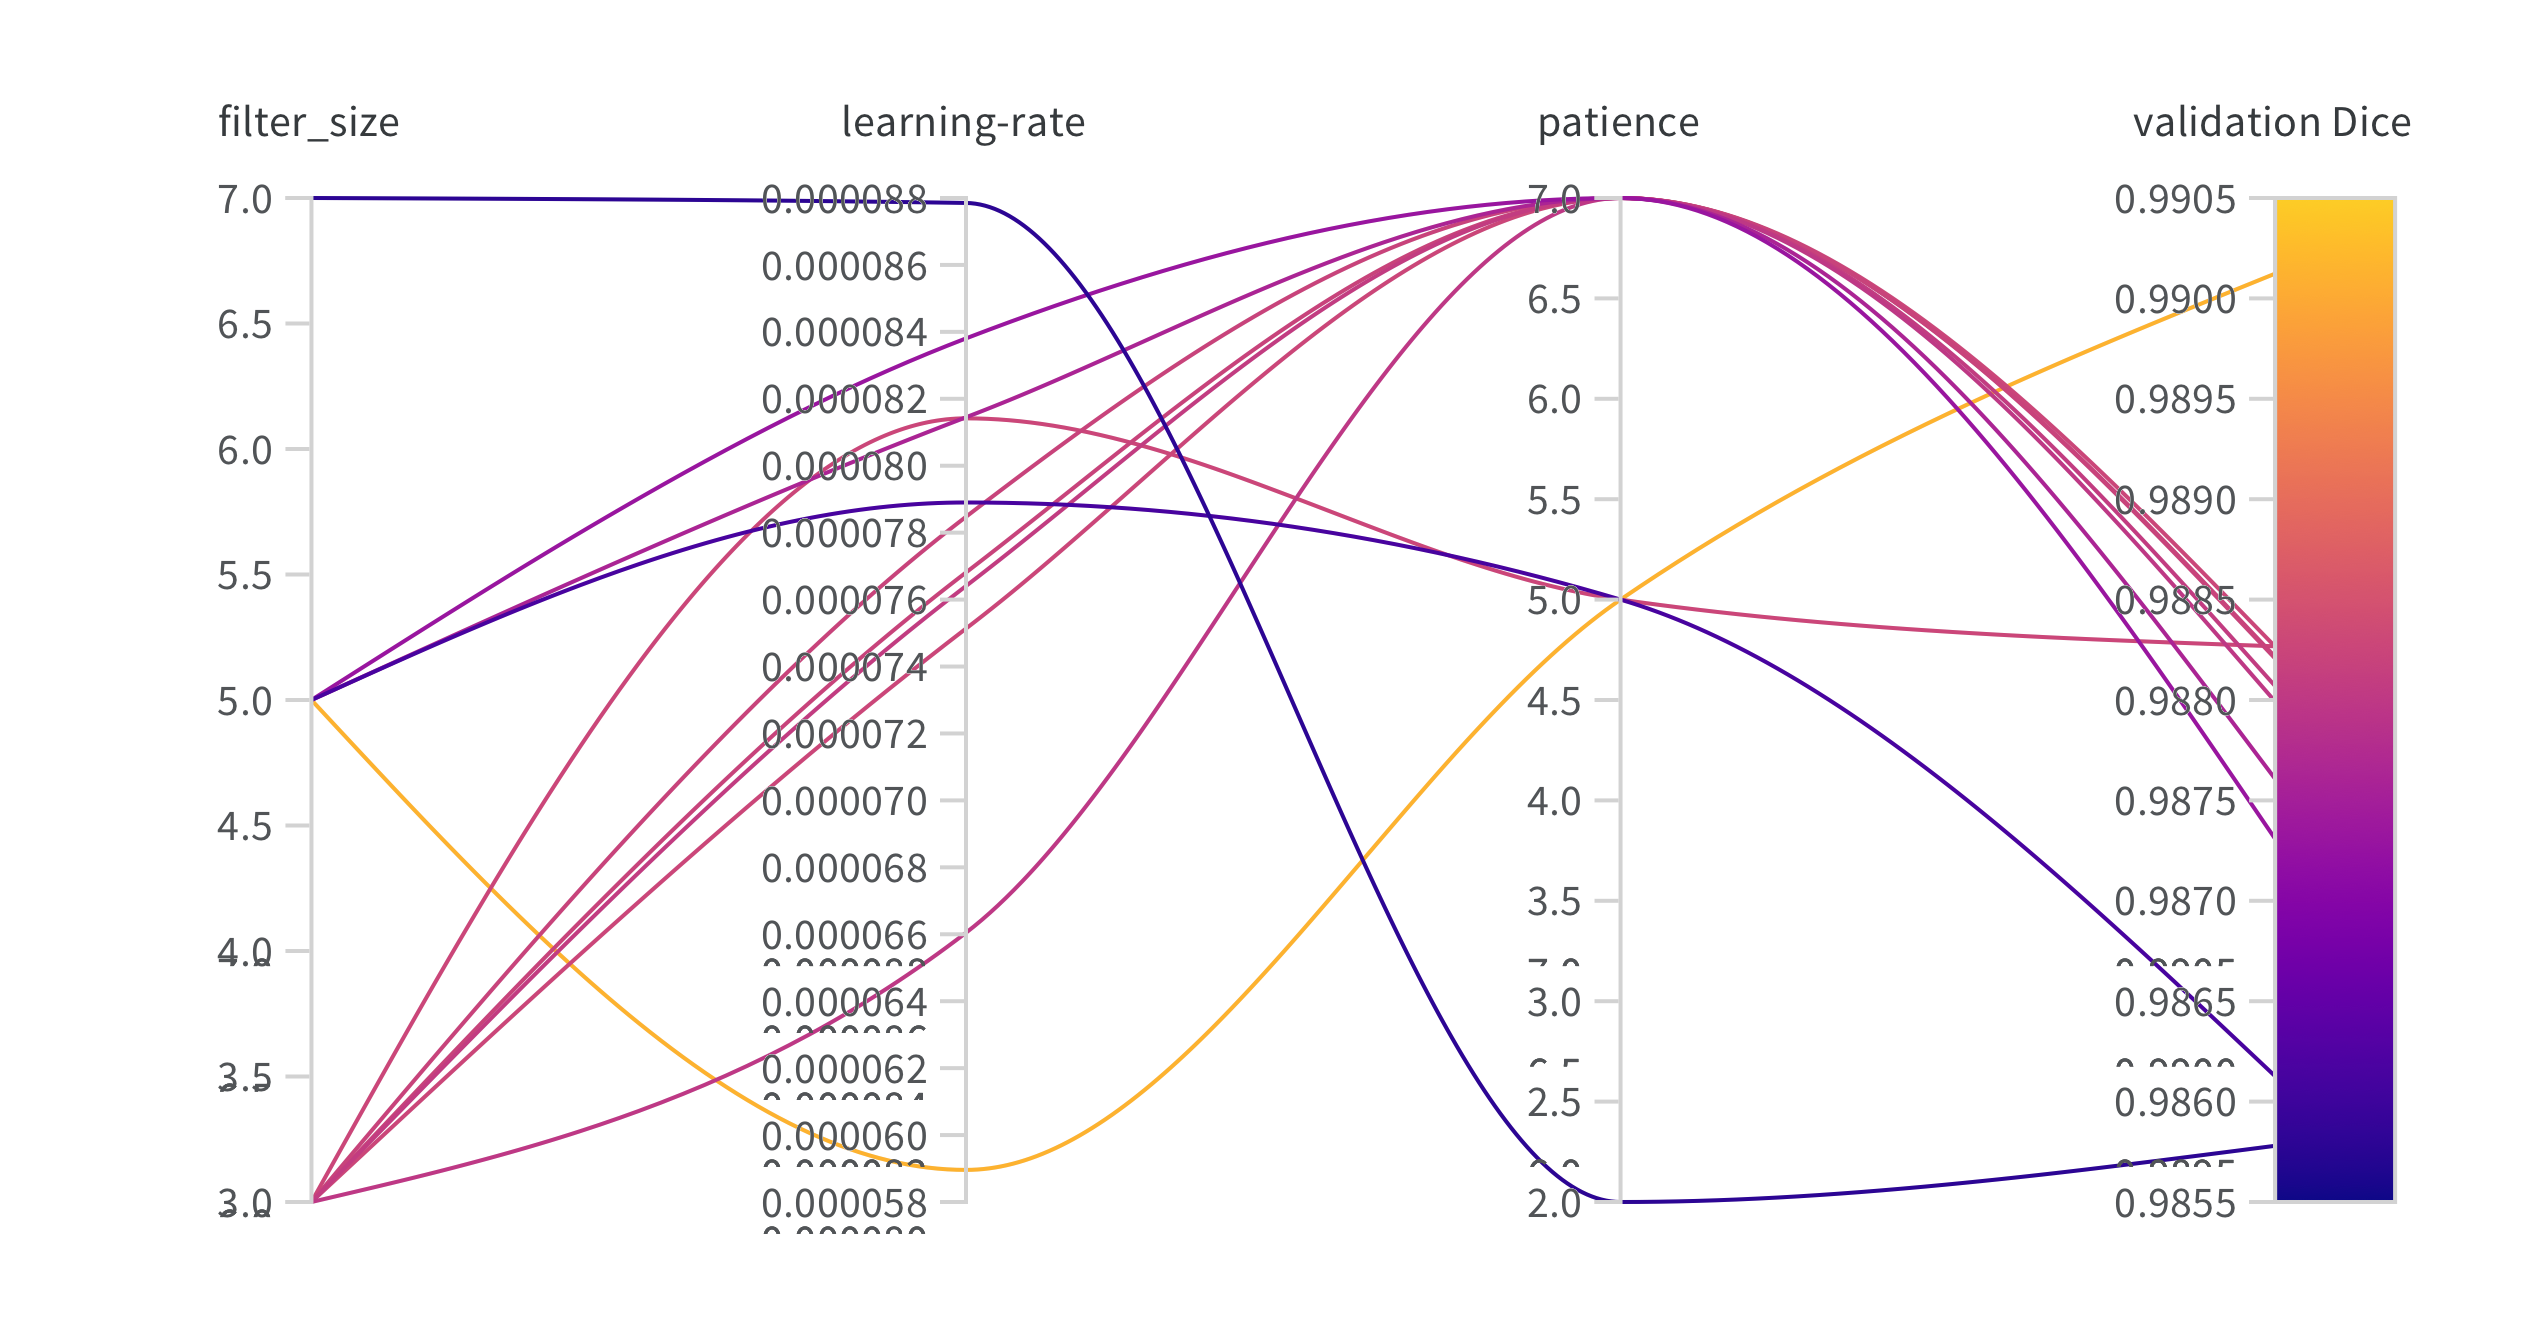

#### Train
For training the UNet we have used outsource GPU with the whole dataset

**Training via Colab is imposible because it throwing RAM error**

In [13]:
# untrained_unet = UNet(3, 2).to(device)
# net = train_net(untrained_unet, device, mini_train_set, mini_train_set, epochs=40, batch_size=16)


As in the benchmark, we do not use a validation set. Hence, the following figure represent the train losses Learning Curves.
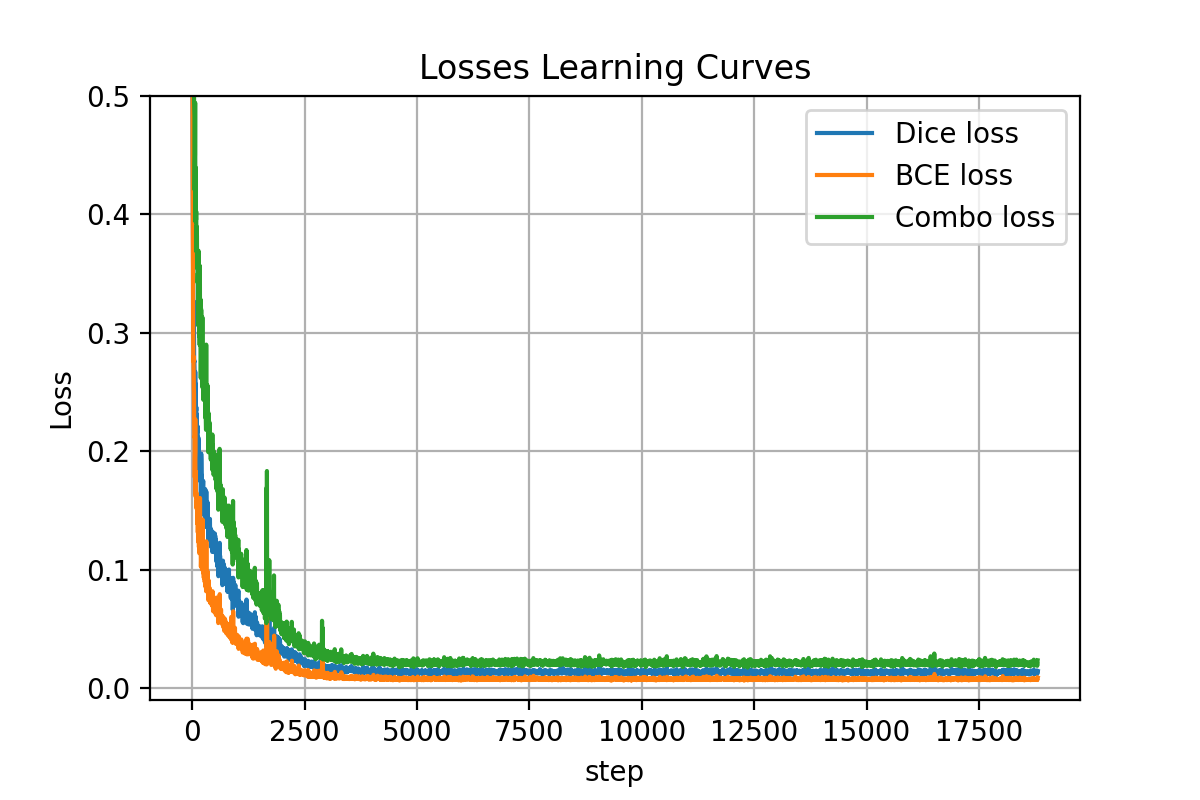

## Corners Coordinates Extraction

### Edge Detector

We implemented here a simple edge detector that runs over all pixels and removes the interior of the document shape from the masked image

In [14]:
def edge(img):
    img_cpy = np.copy(img)
    x_size, y_size = img.shape
    for row in range(1, x_size-1):
        for col in range(1, y_size-1):
            if img[row, col] == 1:
                if (img[row+1, col] == 1) and (img[row-1, col] == 1) and (img[row, col+1] == 1) and (img[row, col-1] == 1):
                    img_cpy[row, col] = 0
    return img_cpy

def DerivativeEdges(img):
    derivative_img = edge(img)
    return derivative_img


### Hough Transform
The Standard Hough Transform (SHT) is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of lines in an image. 

The Standard Hough Transform (SHT) uses the parametric representation of a line:

$\rho = x\cdot cos(\theta) + y\cdot sin(\theta)$.

The variable $\rho$ is the distance from the origin to the line along a vector perpendicular to the line. $\theta$ is the angle of the perpendicular projection from the origin to the line measured in degrees clockwise from the positive x-axis. The range of $\theta$ is $–90^{\circ} \leq \theta \leq 90^{\circ}$. 
The angle of the line itself is $\theta + 90^{\circ}$, also measured clockwise with respect to the positive x-axis.

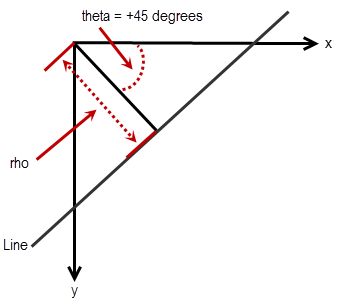

The SHT is a parameter space matrix whose rows and columns correspond to $\rho$ and $\theta$ values respectively. The elements in the SHT represent accumulator cells. Initially, the value in each cell is zero. Then, for every "True value" point in the binary image, $\rho$ is calculated for every $\theta$. $\rho$ is rounded off to the nearest allowed row in SHT. That accumulator cell is incremented. At the end of this procedure, a value of $z$ in SHT(r,c) means that $z$ points in the xy-plane lie on the line specified by $\theta[c]$ and $\rho[r]$. Peak values in the SHT represent potential lines in the input image.

In [15]:
def CalculateHoughMatrix(edge_image, num_rhos=180, num_thetas=360):
    '''
    The input image shall be a logic image, i.e. only 0 and 1
    '''
    # Extract Image size
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    thetas = np.arange(-90, 90, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    # Calculate Cosine and Sinus values of the axis
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    # Calculate the edge point indices from the edge image
    edge_points = np.argwhere(edge_image != 0)
    # Transform the axis to support negative rhos and thetas
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    # Calculate the Rho Values in a Matrix formation
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
    # Calculate the Hough Matrix
    accumulator = np.zeros((len(rhos), len(rhos)))
    accumulator, theta_vals, rho_vals = np.histogram2d(np.tile(thetas, rho_values.shape[0]), rho_values.ravel(), bins=[thetas, rhos])
    accumulator = np.transpose(accumulator)
    return accumulator, rhos, thetas

def CalculateHoughPeaks(H, numPeaks, threshold):
    done = False
    new_H = np.copy(H)
    peaks = []
    # Define neighborhood size
    nhood = np.array((H.shape[0] / 50, H.shape[1] / 50))
    nhood = [max(2 * np.ceil(elem / 2) + 1, 1) for elem in nhood]
    # Calculate neighborhood center
    nhood_center = [(elem-1)/2 for elem in nhood]
    THETA = 1
    RHO = 0
    while not done:
        # Extract the coordinates of rho and theta from the new Hough Matrix
        index = np.unravel_index(np.argmax(new_H), np.array(new_H).shape)
        max_val = new_H[index]
        # Check if this value sustain our predefined threshold for being an actual line in the original image
        if max_val > threshold:
            peaks.append(index)
            # Calculate the centers for both Rho and Theta from the chosen index
            theta_center, rho_center = index[THETA], index[RHO]
            # Calculate the neighborhood for both Rho and Theta from the chosen index around the current center
            theta_low_bound, rho_low_bound = theta_center - nhood_center[THETA], rho_center - nhood_center[RHO]
            theta_high_bound, rho_high_bound = theta_center + nhood_center[THETA], rho_center + nhood_center[RHO]
            
            # Generate a Grid of Rhos and Thetas Combination around the maximal point
            [rhos, thetas] = np.meshgrid(np.arange(np.max((0, rho_low_bound)), np.min((rho_high_bound, new_H.shape[RHO]))+1),
                                   np.arange(theta_low_bound, theta_high_bound + 1))
            '''
            The following Code just changes the values around the following peak to be 0 so we will not choose 
            any of them in the next round.
            '''
            rhos = rhos.ravel()
            thetas = thetas.ravel()

            theta_too_low = np.argwhere(thetas < 0)
            thetas[theta_too_low] = new_H.shape[1] + thetas[theta_too_low]
            rhos[theta_too_low] = new_H.shape[0] - rhos[theta_too_low]

            theta_too_high = np.argwhere(thetas >= new_H.shape[THETA])
            thetas[theta_too_high] = thetas[theta_too_high] - new_H.shape[THETA]
            rhos[theta_too_high] = new_H.shape[RHO] - rhos[theta_too_high]
            new_H[rhos.astype(np.int64), thetas.astype(np.int64)] = 0
            done = len(peaks) == numPeaks
        else:
            done = True
    return np.array(peaks)


### Proposed Hand-Crafted Clustring Method

Because the masked image is not a perfect quadrilateral, by taking the 4 peaks from the SHT matrix we often will not get the 4 lines that represent the quadrilateral. To solve this problem, we first pick 20 peaks from the SHT matrix. By doing this, there is a high probability that the 4 required lines are in the set of these 20 lines (each line represented by the pair $(\rho,\theta)$). The next step is to find these 4 lines. For that, we perform the Kmeans algorithm [4] over the $\theta$'s values of all the 20 lines; with $K=2$ and with $K=3$. We then calculate the Siloueght score [5] over each $K$ and check for which the maximal values are achieved. The Siloueght score is a measure of "how well" the clustering algorithm fits the data. The reason for doing this is that the masked shape is a kind of quadrilateral, hence among the 4 lines representing this shape, there are 2 pairs of "almost parallel" lines, therefore we expect to have 2 clusters when we cluster according to $\theta$. Because of that, if the maximal Silhouette score is achieved for $K=2$ we can be more confident that the 20 peaks represent lines that are close to the 4 true lines. Otherwise, if the maximal Silhouette score is achieved for $K=3$, then some of the predicted lines have to be discarded. In this case, we are discarding all the lines that belong to the cluster with the smaller number of points.
The next step is to apply 2D Kmeans (over both $\rho$, and $\theta$) with $K=4$  over all the reminded lines points (represented by  $(\rho,\theta)$). We then set the 4 centroids as the initial estimation of the 4 lines.


In [16]:
def applyKmenas(thetas, rhos):
    sil = []
    kmax = 3
    expanded_theta = np.expand_dims(thetas, -1)
    for k in range(2, kmax + 1):
        kmeans = KMeans(n_init=20, random_state=1, max_iter=1000, tol=1e-6, n_clusters=k).fit(expanded_theta)
        labels = kmeans.labels_
        sil.append(silhouette_score(expanded_theta, labels))
    if np.argmax(sil) == 1:
        Centeroids = kmeans.cluster_centers_
        secondClusters = Centeroids
        ClusterMapping = kmeans.labels_
        args = np.argsort(Centeroids, axis=0)
        left_center = args[0]
        right_center = args[2]
        num_left = sum(ClusterMapping == left_center)
        num_right = sum(ClusterMapping == right_center)
        if num_left < num_right:
            thetas = thetas[ClusterMapping != left_center]
            rhos = rhos[ClusterMapping != left_center]
        else:
            thetas = thetas[ClusterMapping != right_center]
            rhos = rhos[ClusterMapping != right_center]

    clusterSize = 4
    kmeans = KMeans(n_clusters=clusterSize).fit(np.column_stack((thetas, rhos)))
    Centeroids = kmeans.cluster_centers_
    args = np.argsort(np.abs(Centeroids[:, 0]), axis=0)
    peaks = Centeroids[args, :]
    return peaks


### Estimate Corners via Line Intersections
Now, when we have the 4 estimated lines in polar representation, we convert them to the standard representation ($y=mx+b$) and analytically calculates the intersections between each pair of relevant lines. A relevant lines pair is a pair of lines that are not "almost parallel". We can easily identify them from the clustering over $\theta$ from the previous step.



In [17]:
def FindIntersectionsInXYRepresentation(peaks):
    def find_x(rhos, thetas):
        assert len(rhos) == 2
        assert len(thetas) == 2
        rad_thetas = np.deg2rad(thetas)
        denom = np.zeros((2,1))
        numerator = np.zeros((2, 1))
        for idx, data in enumerate(zip(rhos, rad_thetas)):
            rho, theta = data
            denom[idx] = np.cos(theta) / np.sin(theta)
            numerator[idx] = rho / np.sin(theta)
        '''
        Calculate the following equation
        X = (rho0 / sin(theta0) - rho1 / sin(theta1)) / (cos(theta0) / sin(theta0) - cos(theta1) / sin(theta1))
        '''
        x = (numerator[0] - numerator[1]) / (denom[0] - denom[1])
        return x

    def find_y(rho, theta, x):
        rad_theta = np.deg2rad(theta)
        '''
        Calculate the following equation
        Y = rho/sin(theta)-x*cos(theta)/sin(theta);
        '''
        y = rho/np.sin(rad_theta) - x*np.cos(rad_theta)/np.sin(rad_theta)
        return y

    assert peaks.shape[0] == 4
    X = 0
    Y = 1
    THETA = 0
    RHO = 1
    corners_estimation = np.zeros_like(peaks)
    # Sort according to theta
    sorted_args = np.argsort(peaks[:, THETA], axis=0)
    sorted_peaks = peaks[sorted_args]
    sorted_peaks[np.abs(sorted_peaks[:, THETA]) < 0.001, THETA] = 0.001
    # Generate intersection pairs in a list formation
    [THETAS, RHOS] = np.meshgrid(range(0, 2), range(2, 4))
    peaks_pairs = [(sorted_peaks[i], sorted_peaks[j]) for i, j in zip(THETAS.ravel(), RHOS.ravel())]
    for corner_idx, pair in enumerate(peaks_pairs):
        thetas = []
        rhos = []
        thetas.extend([peak[THETA] for peak in pair])
        rhos.extend([peak[RHO] for peak in pair])
        corners_estimation[corner_idx][X] = find_x(rhos, thetas)
        corners_estimation[corner_idx][Y] = find_y(rho=pair[0][RHO], theta=pair[0][THETA], x=corners_estimation[corner_idx][X])
    return corners_estimation


## Corners Estimation Refiner
To further improve the corners estimation, for each corner, we check for the closest point to this corner among all the edges points in the edged masked image. This way, we can get closer to the true corner estimation because we know that this is should be near the edges of the masked image.

In [18]:
def closest_point(edge_img, corners):
    # Find the indices where the edge appears in the mask
    doc_edges_indices = np.where(edge_img == 1)
    # Transform it to matrix representation
    doc_edges_indices = np.array(list(doc_edges_indices)).T
    # Find the distances in x axis
    x_dist = np.square((np.expand_dims(corners[:, 0], axis=1) - np.expand_dims(doc_edges_indices[:, 0], axis=0)))
    # Find the distances in y axis
    y_dist = np.square((np.expand_dims(corners[:, 1], axis=1) - np.expand_dims(doc_edges_indices[:, 1], axis=0)))
    # Find the approximated distance ~ we dont use square root and mean in order to accelerate  
    distance_vec = x_dist + y_dist
    # Find the minimum distance indices
    idx = np.argmin(distance_vec, axis=1)
    # Fine tune the corner estimation
    closest_point = doc_edges_indices[idx]
    return closest_point


##Results

Loading the trained UNet weights

In [19]:
w_path = "/content/drive/MyDrive/DeepLearningProject/Checkpoints/Hough_UNet/Unet512x512_checkpoint_filter_5x5.pth"
pretrained_unet = UNet(3, 2)
pretrained_unet.load_state_dict(torch.load(w_path, map_location=torch.device('cpu')))

<All keys matched successfully>

###Flow Visualization

In [20]:
def plot_hough(H, estimated_peaks, hough_peaks, T, R):
    """
    This function prints the Hough Matrix
    """
    fig, ax = plt.subplots(1, 1)
    ax.imshow(np.log1p(H))
    ax.scatter(hough_peaks[:, 1], hough_peaks[:, 0], c='red', label="Hough peaks")
    newThetaAxis = (np.digitize(estimated_peaks[:, 0], T)) 
    newRhoAxis = np.digitize(estimated_peaks[:, 1], R)
    ax.scatter(newThetaAxis, newRhoAxis, c='yellow', label="Estimated lines")
    ax.set_title("Hough Matrix")
    plt.xticks(list(range(0,360,20)),list(range(-90,90,10)))
    plt.yticks(list(range(0,180,10)),list(range(-90,90,10)))
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\rho$')
    plt.legend()
    plt.show()
    

In [21]:
def plot_img_and_mask(img, mask, corners):
    """
    This function prints an img,  its ground truth mask, and also prints a given corners indices over them
    """
    classes = mask.shape[0] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    ax[0].scatter(corners[:, 0], corners[:, 1], c='red')
    if classes > 1:
        for i in range(classes):
            ax[i + 1].set_title(f'Output mask (class {i + 1})')
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].scatter(corners[:, 0], corners[:, 1], c='red')
    else:
        ax[1].set_title(f'Ground Truth Mask')
        ax[1].imshow(mask)
        ax[1].scatter(corners[:, 0], corners[:, 1], c='red')
    plt.xticks([]), plt.yticks([])
    plt.show()

#### Predicted Mask via UNet

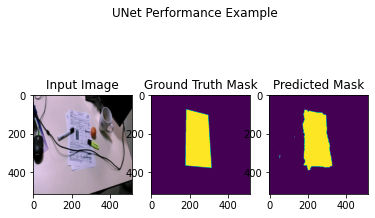

In [22]:
data_example = test_set_bg_5[3]
# precalculated mean and std over the full train set
train_mean = 151.84097687205238 
train_std = 43.61468699572161
img = data_example['image']
gt_mask = data_example['mask'].T
norm_img = (img - train_mean) / train_std
gt_coords = list(data_example['label'].numpy())
pred_mask = pretrained_unet(norm_img.unsqueeze(dim=0).to(device)).detach()
pred_mask = F.one_hot(pred_mask.argmax(dim=1), pretrained_unet.n_classes).permute(0, 3, 1, 2).float().numpy()[0,1,:,:].T
fig, ax = plt.subplots(1, 3)
fig.suptitle('UNet Performance Example')
ax[0].set_title('Input Image')
ax[0].imshow(img.transpose(0,-1).int())
ax[1].set_title('Ground Truth Mask')
ax[1].imshow(gt_mask)
ax[2].set_title('Predicted Mask')
ax[2].imshow(pred_mask)

#### Extract Edges

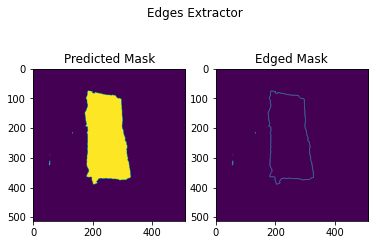

In [23]:
edge_img = DerivativeEdges(pred_mask)
fig, ax = plt.subplots(1, 2)
fig.suptitle('Edges Extractor')
ax[0].set_title('Predicted Mask')
ax[0].imshow(pred_mask)
ax[1].set_title('Edged Mask')
ax[1].imshow(edge_img)


#### Hough Matrix Visualisiation with 20 Peaks and The 4 Predicted Estimated Lines

In [24]:
def e2e_algorithm(img, numPeaks=20):
    # End to End Corner Extraction from the masked image
    edge_image = DerivativeEdges(img)
    H, R, T = CalculateHoughMatrix(edge_image)
    hough_peaks = CalculateHoughPeaks(H, numPeaks, threshold=0.1 * np.max(H))
    thetas = T[hough_peaks[:, 1]]
    rhos = R[hough_peaks[:, 0]]
    estimated_peaks = applyKmenas(thetas, rhos)
    corners_estimation = FindIntersectionsInXYRepresentation(estimated_peaks)
    corners_estimation[:, 0] += img.shape[1]/2
    corners_estimation[:, 1] += img.shape[0]/2
    corners_estimation_closest_point = np.fliplr(closest_point(edge_image, np.fliplr(corners_estimation)))
    return corners_estimation_closest_point, corners_estimation, H, T, R, hough_peaks, estimated_peaks


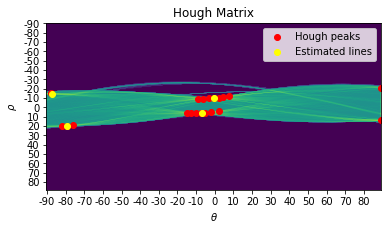

In [25]:
corners_estimation_closest_point, corners_estimation, H, T, R, hough_peaks, estimated_peaks = e2e_algorithm(pred_mask, numPeaks=20)
plot_hough(H, estimated_peaks, hough_peaks, T, R)

#### Corners Prediction

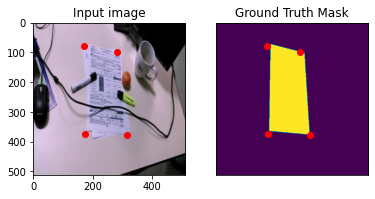

In [26]:
plot_img_and_mask(img.transpose(0,-1).int(), gt_mask, corners_estimation)

#### Corners Prediction after closest point correction

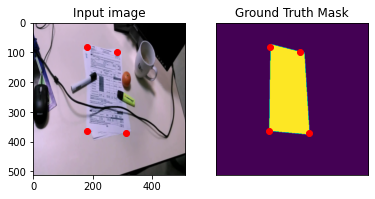

In [27]:
plot_img_and_mask(img.transpose(0,-1).int(), gt_mask, corners_estimation_closest_point)

### Evaluate Dice Score over the test set



In [28]:
def evaluate_e2e_algorithm(dataset, batch_size, net):
    loader_args = dict(batch_size=batch_size, pin_memory=True)
    loader = DataLoader(dataset, shuffle=True, drop_last=True, **loader_args)
    cnt = 0
    dice_score = []
    for batch in loader:
        images = batch['image']
        true_masks = batch['mask']
        images = images.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.long)
        with torch.no_grad():
            masks_pred = net(images)
        predSegment = masks_pred[:, 1, ...]
        predSegment[predSegment < 0.5] = 0
        predSegment[predSegment >= 0.5] = 1
        temp_dice_score = []
        for idx in range(batch_size):
            curr_cleaned_mask = predSegment[idx].detach().cpu().numpy()
            masks_pred = e2e_algorithm(curr_cleaned_mask)[0]
            mask_predicated = gen_mask(masks_pred, sizeX=true_masks[idx].shape[0], sizeY=true_masks[idx].shape[1], sort=True)
            score = dice_coeff(torch.tensor(mask_predicated, dtype=torch.float).to(device), true_masks[idx].type(torch.float))
            # print(score.item())
            temp_dice_score.append(score.item())
        # print(f'Batch-{cnt} - Dice Score = {np.mean(temp_dice_score)}')
        dice_score.extend(temp_dice_score)
        cnt += 1
    # print(f'Total Dice Score Background {bg} = {np.mean(dice_score)}')
    return np.array(dice_score)


Running the following code over the whole test set can take a lot of time. Therefore we ran this offline and report the results:

*   Background01 Average Dice Score - 0.9553858727216721
*   Background02 Average Dice Score - 0.9310153740617327
*   Background03 Average Dice Score - 0.9566100876219571
*   Background04 Average Dice Score - 0.9649384463351706
*   Background05 Average Dice Score - 0.87300871776446 



In [29]:
# pretrained_unet = pretrained_unet.to(device)

# plt.figure()
# res = []
# for idx in range(1,6):
#     curr_dsc = evaluate_e2e_algorithm(eval(f'test_set_bg_{idx}'), 5, pretrained_unet)
#     print(f'bg_{idx}_DSC_Mean = {np.mean(curr_dsc)}')
#     res.append(curr_dsc)
# plt.boxplot(res, positions=[2, 4, 6, 8, 10], showfliers=False)
# plt.grid()
# plt.xticks([2, 4, 6, 8, 10], ['BG 1', 'BG 2', 'BG 3', 'BG 4', 'BG 5'], rotation=20)
# plt.show()

#### Box Plot of Dice Score per Background
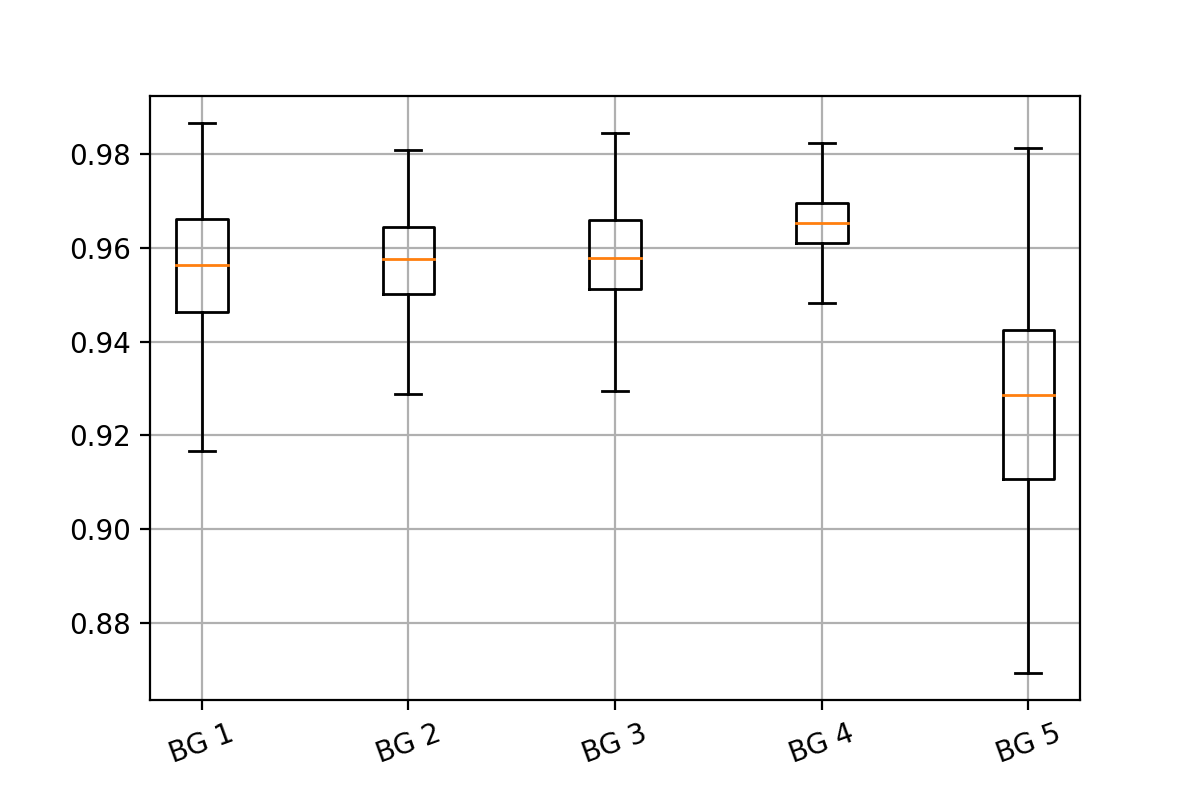


### Algorithm 1 Results Analysis
A few insights from the development of this algorithm

1. It is important to mention that during train and inference we used an images of size 512X512 as opposed to the original images size(that used in the benchmark algorithm and the second proposed algorithm). 
2. Rescaling the predicted corners coordinates to the original images size (1920X1080), induces further error in the estimation. Therefore this algorithm is limited in the sense that we have to use the size of the original images when we feed them to the UNet in order to predict the corresponded corners without an additional estimation error which can be very large. 
3. For image sizes larger than 512X512, the computations become costly. 
4. At the beginning we were able to segment the images properly only when the size of the images was 64X64. When the predicted labels are rescaled to estimate the corners in the 512X512 images this algorithm suffered from a severe error. 
5. To solve this problem, we used 512X512 input images for training. The segmentation results got worst because these images contained more details compared to the smaller images and therefore the UNet captures undesired elements from the images. This lead us to apply a Gaussian filter as part of the Preprocess to make the images blurrier. This allowed us to use the UNet with larger images.






# Recursive CNN Benchmark

We use the work of Khurram Javed, and Faisal Shafait - "Real-time Document Localization in Natural Images by Recursive Application of a CNN"[6] as a benchmark. They used two different convolutional neural networks (CNN) for this task. The first trained to find the four corners indices of each image. Then, they applied a simple algorithm for dividing the image into 4 images such that each image contains one of the predicted corners of the document. The images with the single corner are fed recursively to a second network that is trained to find a corner. This network allows converging to the correct location. In each iteration, they used the model’s prediction to discard a part of the full-resolution image least likely to contain the corner and fed the remaining image to the same network again.

The following figure illustrates this algorithm workflow:

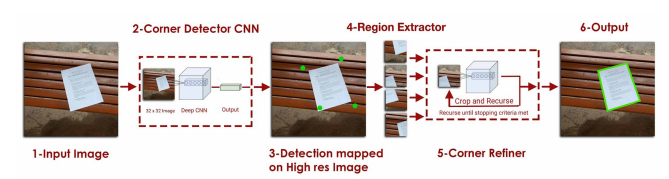

##The two CNN networks architecture
The two networks are the well known ResNet20. [7]

In [30]:
class DownsampleA(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(DownsampleA, self).__init__()
        assert stride == 2
        self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.avg(x)
        return torch.cat((x, x.mul(0)), 1)

class ResNetBasicblock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResNetBasicblock, self).__init__()

        self.conv_a = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn_a = nn.BatchNorm2d(planes)

        self.conv_b = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_b = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.featureSize = 64

    def forward(self, x):
        residual = x

        basicblock = self.conv_a(x)
        basicblock = self.bn_a(basicblock)
        basicblock = F.relu(basicblock, inplace=True)

        basicblock = self.conv_b(basicblock)
        basicblock = self.bn_b(basicblock)

        if self.downsample is not None:
            residual = self.downsample(x)

        return F.relu(residual + basicblock, inplace=True)


class CifarResNet(nn.Module):

    def __init__(self, block, depth, num_classes, input_size = 32, channels=3):
        """ Constructor
        Args:
          depth: number of layers.
          num_classes: number of classes
          base_width: base width
        """
        super(CifarResNet, self).__init__()

        self.featureSize = 64
        # Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
        assert (depth - 2) % 6 == 0
        layer_blocks = (depth - 2) // 6
        assert input_size == 32 or input_size == 64


        self.num_classes = num_classes

        self.conv_1_3x3 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(16)

        self.inplanes = 16
        self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
        self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
        self.stage_3 = self._make_layer(block, 64, layer_blocks, 2)
        if input_size == 32:
            self.avgpool = nn.AvgPool2d(8)
        else:
            # This case the input size is with size of 64
            self.avgpool = nn.AvgPool2d(16)

        self.fc = nn.Linear(64 * block.expansion, num_classes)
        self.fc2 = nn.Linear(64 * block.expansion, 100)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                # m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = DownsampleA(self.inplanes, planes * block.expansion, stride)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, pretrain=False):

        x = self.conv_1_3x3(x)
        x = F.relu(self.bn_1(x), inplace=True)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if pretrain:
            return self.fc2(x)
        x = self.fc(x)
        return x


###Corner Detector ResNet20


In [31]:
num_classes = 8
CDmodel = CifarResNet(ResNetBasicblock, 20, num_classes)

###Corner Refiner ResNet20


In [32]:
num_classes = 2
CRmodel = CifarResNet(ResNetBasicblock, 20, num_classes)

The authors of the aformentiond paper supplied their algorithm implementation code in https://github.com/KhurramJaved96/Recursive-CNNs.
We trained the networks with the same configuration that reported in their paper and evaluated the performance over the test set with the Dice score metric.


*   Background01 Average Dice Score - 0.99030827 
*   Background02 Average Dice Score - 0.98776065
*   Background03 Average Dice Score - 0.9754311
*   Background04 Average Dice Score - 0.97914552
*   Background05 Average Dice Score - 0.96689237

#### Box Plot of Dice Score per Background
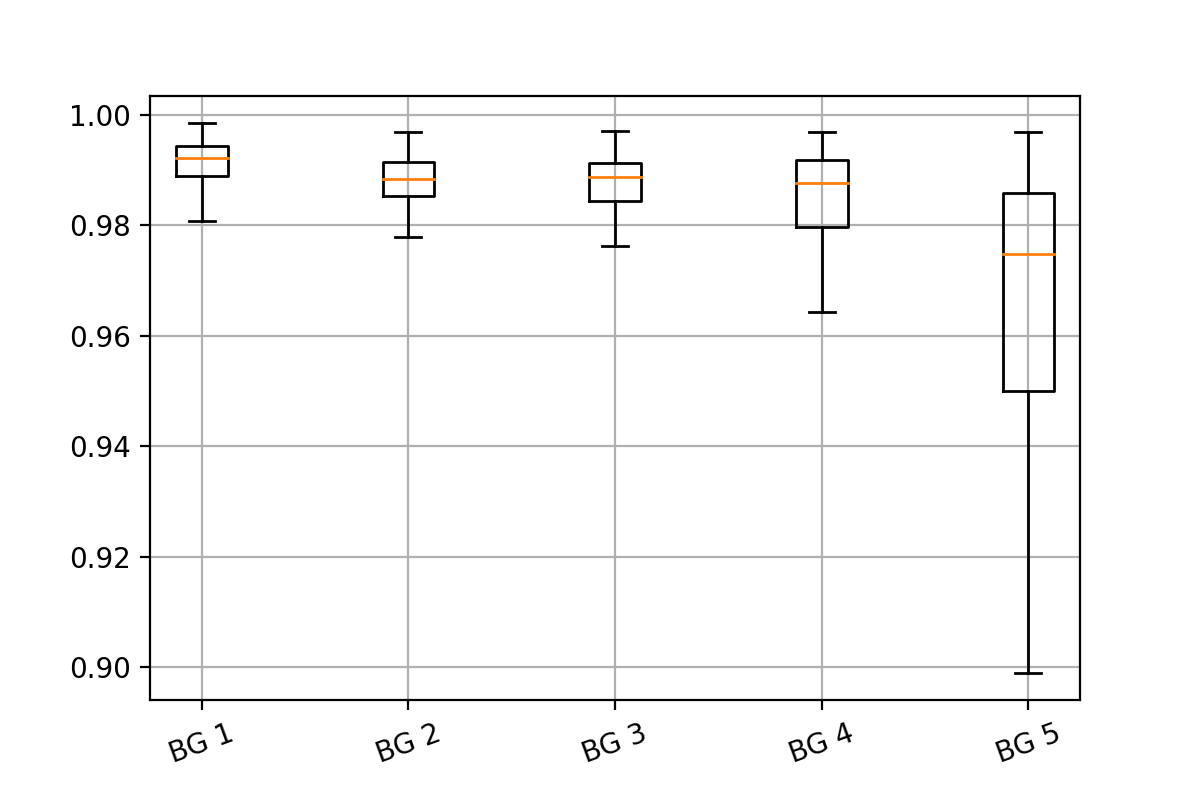

#Proposed Algorithm - V.2

We further developed an algorithm that is a combination of techniques from the benchmark and the proposed V.1 algorithm. In this algorithm, we adapt the main ideas from the benchmark algorithm while we integrate a segmenation unit into the Corners Detector and the Corner Refiner architectures.

##Corners Detector Architecture

This network is used to estimate the 4 corners of the document. For that, we used the output of a UNet as an input to a ResNet20 network. Then, we calculate the Combo Loss over the UNet output and an MSE loss over the ResNet output. We define our network's loss as the summation of these losses. 

###Corners Detector Architecture Illustration
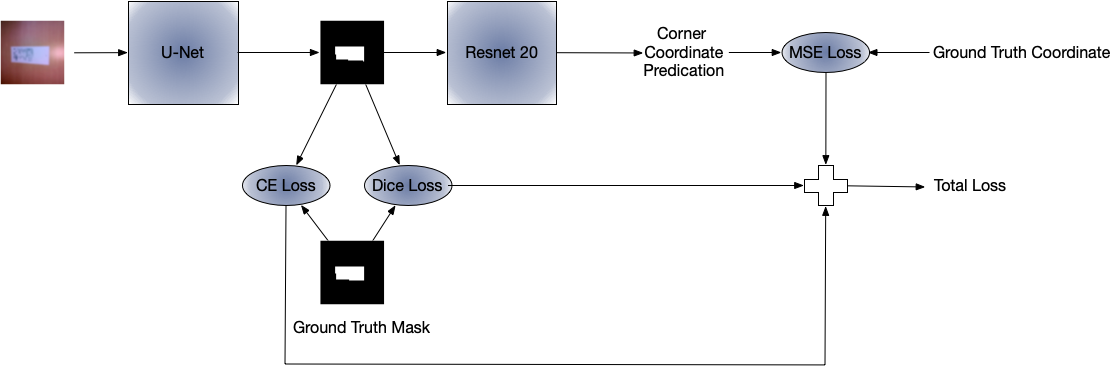

##Corners Refiner Architecture

This network is used to estimate a single corner from a cropped image. In this case, the input to the ResNet20 network is a concatenation of the input image  with the UNet output along the channel axis, similarly to the original Corner Detector network. We define the loss function for the network as the same loss of the Corner Detector network.

## Corner Refiner Architecture Illustration
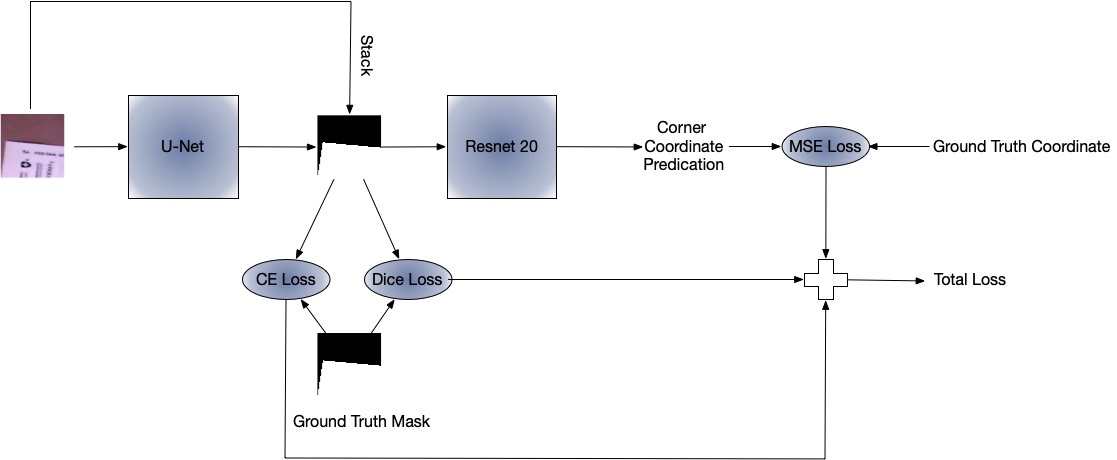

In [33]:
# The following function combines the benchmark model such that it is able to use our Unet mask's predication.
def MaskedDocumentResnet(num_classes, numInputChannels, input_size):
    net = CifarResNet(ResNetBasicblock, 20, num_classes,input_size=input_size).float()
    kernel_size = 5
    return nn.Sequential(nn.Conv2d(numInputChannels, 3, kernel_size, padding='same'), net).float()

# The following dictionary contains all of our models to solve this task using this method.
models = {'document': {}, 'corner': {}}
# Initialize the CNN based ducment's corner regresssor combined with the corresponding UNet.
cnn_net = MaskedDocumentResnet(num_classes=8, numInputChannels=2, input_size=64).to(device)
Unet = UNet(n_channels=3, n_classes=2, bilinear=True).to(device)
models['document']['CNN'] = cnn_net
models['document']['UNET'] = Unet
cnn_net_corner = MaskedDocumentResnet(num_classes=2, numInputChannels=5, input_size=64).to(device)
Unet_corner = UNet(n_channels=3, n_classes=2, bilinear=True).to(device)
models['corner']['CNN'] = cnn_net_corner
models['corner']['UNET'] = Unet_corner

In [34]:
def evaluateE2eModel(Unet,CorExtractor, dataloader, device):
    Unet.eval()
    CorExtractor.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    mse_loss = nn.MSELoss()
    val_loss = 0
    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true, labels = batch['image'], batch['mask'], batch['label']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        labels = labels.to(device=device, dtype=torch.float32)
        mask_true = F.one_hot(mask_true, Unet.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = Unet(image)
            # new_imgs = torch.concat([mask_pred, image], dim=1)
            new_imgs = torch.mul(mask_pred, image)
            corners_pred = CorExtractor(new_imgs)

            # convert to one-hot format
            if Unet.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), Unet.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)
            val_loss += mse_loss(corners_pred, labels)
    Unet.train()
    CorExtractor.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches, val_loss / num_val_batches

### The training function

In [35]:
def train_combined_model(Unet,
              CornerExtractor,
              device,
              train_set,
              val_set,
              mode,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 0.001,
              amp: bool = False,
              patience: int = 5):

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    n_train = len(train_set)
    n_val = len(val_set)
    print(f'''Starting training:
              Epochs:          {epochs}
              Batch size:      {batch_size}
              Learning rate:   {learning_rate}
              Training size:   {n_train}
              Validation size: {n_val}
              Device:          {device.type}
              Mixed Precision: {amp} 
              Patience: {patience}''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    Unet_optimizer = optim.RMSprop(Unet.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    CornerExtractor_optimizer = optim.SGD(filter(lambda p: p.requires_grad, CornerExtractor.parameters()), learning_rate,
                                          momentum=0.9,
                                          weight_decay=1e-5, nesterov=True)
    # Goal: maximize Dice score
    schedulerUnet = optim.lr_scheduler.ReduceLROnPlateau(Unet_optimizer, 'max', patience=patience, factor=0.5) 
    # Goal: minimize mse loss
    schedulerCornerExtractor = optim.lr_scheduler.ReduceLROnPlateau(CornerExtractor_optimizer, 'min', patience=patience, factor=0.5)  
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    Unet_criterion = nn.CrossEntropyLoss()
    CornerExtractor_criterion = nn.MSELoss()

    global_step = 0

    # 5. Begin training
    for epoch in range(epochs):
        Unet.train()
        CornerExtractor.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']
                labels = batch['label']
                print(labels.shape)
                assert images.shape[1] == Unet.n_channels, \
                    f'Network has been defined with {Unet.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)
                labels = labels.to(device=device, dtype=torch.float32)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = Unet(images)
                    if mode == "corner":
                      new_imgs = torch.concat([masks_pred, images], dim=1)
                    else:
                      new_imgs = masks_pred
                    labels_pred = CornerExtractor(new_imgs)
                    ce_loss = Unet_criterion(masks_pred, true_masks)
                    curr_dice_loss = dice_loss(F.softmax(masks_pred, dim=1).float(), F.one_hot(true_masks, Unet.n_classes).permute(0, 3, 1, 2).float())
                    mse_loss = CornerExtractor_criterion(labels_pred, labels)
                    overall_loss = ce_loss + curr_dice_loss + mse_loss

                Unet_optimizer.zero_grad(set_to_none=True)
                CornerExtractor_optimizer.zero_grad(set_to_none=True)

                grad_scaler.scale(overall_loss).backward()
                grad_scaler.step(Unet_optimizer)
                grad_scaler.step(CornerExtractor_optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                pbar.set_postfix(**{'loss Unet (batch)': overall_loss.item(), 'loss Corner Extractor (batch)': mse_loss.item()})

                # Evaluation round
                division_step = (n_train // 2) 
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_dice_score, val_score = evaluateE2eModel(Unet, CornerExtractor, val_loader, device)
                        schedulerUnet.step(val_dice_score)
                        schedulerCornerExtractor.step(val_score)

### Generating the Datasets:

As the dataset is large we load only a single sample from each video.

(When we trained the model in an out-source server we used the whole dataset)

In [36]:
# 
FILTER_SIZE = 3
CROP_SIZE = 64
DOCUMENT_SIZE = 64
CORNER_SIZE = 512
FRAMES_PER_VIDEO = 1
# Document dataset creation
mini_document_train_set = DocumentDatasetMaskSegmentation(Path='/content/drive/MyDrive/DeepLearningProject/data/Train', frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': None}, Size=DOCUMENT_SIZE)
document_test_set = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (train_mean, train_std)}, Size=DOCUMENT_SIZE)
# Corner dataset creation
mini_corner_train_set = DocumentDatasetMaskSegmentation(Path='/content/drive/MyDrive/DeepLearningProject/data/Train',  frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'RandomCropNearCorner': CROP_SIZE, 'Normalize': None}, Size=CORNER_SIZE)
corner_test_set = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'RandomCropNearCorner': CROP_SIZE, 'Normalize': (train_mean, train_std)}, Size=CORNER_SIZE)



Ground Truth Shape: %s (100, 8)
Data shape %s 100


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Ground Truth Shape: %s (25, 8)
Data shape %s 25


100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


Ground Truth Shape: %s (100, 8)
Data shape %s 100


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


Ground Truth Shape: %s (25, 8)
Data shape %s 25


100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


### Train
**The model is trained in an out-source server with the whole dataset**

In [37]:
SCHEDULER_PATIENCE = 2
LearningRate = 0.00001
BATCH_SIZE = 16
EPOCHS = 40

# train_combined_model(Unet=models['document']['UNET'],
#       CornerExtractor = models['document']['CNN'],
#       train_set = mini_document_train_set,
#       val_set = mini_document_train_set,
#       mode = 'document',
#       epochs=EPOCHS, 
#       batch_size=BATCH_SIZE,
#       learning_rate=LearningRate,
#       device=device,
#       amp=False,
#       patience=SCHEDULER_PATIENCE)

# train_combined_model(Unet=models['corner']['UNET'],
#       CornerExtractor = models['corner']['CNN'],
#       train_set=mini_corner_train_set,
#       val_set = mini_corner_train_set,
#       mode = 'corner',
#       epochs=EPOCHS,
#       batch_size=BATCH_SIZE,
#       learning_rate=LearningRate,
#       device=device,
#       amp=False,
#       patience=SCHEDULER_PATIENCE)


## Results


In [38]:
def preprocess_image(img_path, mode):
    """
    This function resizes the image size to 64X64, apply a gussian filter, and normalize it according to the train statistics
    """
    img = Image.open(img_path)
    copy_img = deepcopy(img)
    if mode == 'Ours':
        copy_img = copy_img.resize((64, 64))
        np_img = np.array(copy_img).T
        pil_img = Image.fromarray(np_img.T.astype('uint8'), 'RGB')
        transformed_img = np.array(transforms.GaussianBlur(3)(pil_img), dtype=np.float32).T
        transformed_img = (transformed_img - 151.84097687205238) / 43.61468699572161
    else:
        transformed_img = copy_img.resize((32, 32))
        np_img = np.array(transformed_img).T
        pil_img = Image.fromarray(np_img.T.astype('uint8'), 'RGB')
        transformed_img = np.array(transforms.ToTensor()(pil_img), dtype=np.float32).T
    return img, transformed_img

In [48]:
class GetCorners:
    """
    This object, predicts the initial prediction of the 4 corners and divides the image into four images according to this prediction.(hopfully each image contains a single corner)
    """
    def __init__(self, checkpoint_dir, input_size, mode):
        self.model = models['document']['CNN']
        self.model.load_state_dict(torch.load(checkpoint_dir, map_location='cpu'))
        self.model.eval()

    def get(self, mask, image_array):
        with torch.no_grad():
            model_prediction = self.model(mask).cpu().data.numpy()[0]

            model_prediction = np.array(model_prediction)

            x_cords = model_prediction[[0, 2, 4, 6]]
            y_cords = model_prediction[[1, 3, 5, 7]]

            x_cords = x_cords * image_array.shape[1]
            y_cords = y_cords * image_array.shape[0]

            # Extract the four corners of the image. Read "Region Extractor" in Section III of the paper for an explanation.

            top_left = image_array[
                       max(0, int(2 * y_cords[0] - (y_cords[3] + y_cords[0]) / 2)):int((y_cords[3] + y_cords[0]) / 2),
                       max(0, int(2 * x_cords[0] - (x_cords[1] + x_cords[0]) / 2)):int((x_cords[1] + x_cords[0]) / 2)]

            top_right = image_array[
                        max(0, int(2 * y_cords[1] - (y_cords[1] + y_cords[2]) / 2)):int((y_cords[1] + y_cords[2]) / 2),
                        int((x_cords[1] + x_cords[0]) / 2):min(image_array.shape[1] - 1,
                                                               int(x_cords[1] + (x_cords[1] - x_cords[0]) / 2))]

            bottom_right = image_array[int((y_cords[1] + y_cords[2]) / 2):min(image_array.shape[0] - 1, int(
                y_cords[2] + (y_cords[2] - y_cords[1]) / 2)),
                           int((x_cords[2] + x_cords[3]) / 2):min(image_array.shape[1] - 1,
                                                                  int(x_cords[2] + (x_cords[2] - x_cords[3]) / 2))]

            bottom_left = image_array[int((y_cords[0] + y_cords[3]) / 2):min(image_array.shape[0] - 1, int(
                y_cords[3] + (y_cords[3] - y_cords[0]) / 2)),
                          max(0, int(2 * x_cords[3] - (x_cords[2] + x_cords[3]) / 2)):int(
                              (x_cords[3] + x_cords[2]) / 2)]

            top_left = (top_left, max(0, int(2 * x_cords[0] - (x_cords[1] + x_cords[0]) / 2)),
                        max(0, int(2 * y_cords[0] - (y_cords[3] + y_cords[0]) / 2)))
            top_right = (
            top_right, int((x_cords[1] + x_cords[0]) / 2), max(0, int(2 * y_cords[1] - (y_cords[1] + y_cords[2]) / 2)))
            bottom_right = (bottom_right, int((x_cords[2] + x_cords[3]) / 2), int((y_cords[1] + y_cords[2]) / 2))
            bottom_left = (bottom_left, max(0, int(2 * x_cords[3] - (x_cords[2] + x_cords[3]) / 2)),
                           int((y_cords[0] + y_cords[3]) / 2))

            return top_left, top_right, bottom_right, bottom_left
    def get_corners(self, mask, image):
        with torch.no_grad():

            model_prediction = self.model(mask.float()).cpu().data.numpy()[0]

            model_prediction = np.array(model_prediction)

            x_cords = model_prediction[[0, 2, 4, 6]]
            y_cords = model_prediction[[1, 3, 5, 7]]

            x_cords = x_cords * image.shape[1]
            y_cords = y_cords * image.shape[0]
        return  [(i, j) for i,j in zip(x_cords, y_cords)]

In [49]:
class corner_finder():
    """
    This image takes an image with a single corner, concatenate to it the predicted masked image along the channel axis and predicts the corner recursievely.
    """
    def __init__(self, CHECKPOINT_DIR, mode,input_size):
        self.model = models['corner']['CNN']
        self.model.load_state_dict(torch.load(CHECKPOINT_DIR, map_location='cpu'))
        self.model.eval()
        self.mode = mode

    def get_location(self, img, unet, retainFactor=0.85):
        with torch.no_grad():
            ans_x = 0.0
            ans_y = 0.0

            o_img = np.copy(img)

            y = [0, 0]
            x_start = 0
            y_start = 0
            up_scale_factor = (img.shape[1], img.shape[0])

            myImage = np.copy(o_img)


            CROP_FRAC = retainFactor
            while (myImage.shape[0] > 10 and myImage.shape[1] > 10):
                if self.mode == 'Ours':
                    pil_img = Image.fromarray(myImage.astype('uint8'), 'RGB').resize((64, 64))
                    transformed_img = np.array(transforms.GaussianBlur(3)(pil_img), dtype=np.float32).T
                    img_temp = (transformed_img - 151.84097687205238) / 43.61468699572161
                else:
                    pil_img = Image.fromarray(myImage.astype('uint8'), 'RGB').resize((32, 32))
                    img_temp = np.array(transforms.ToTensor()(pil_img), dtype=np.float32)
                img_temp = torch.tensor(img_temp).unsqueeze(0)
                if self.mode == 'benchMark':
                    mask = img_temp
                else:
                    mask = unet(img_temp)
                    mask = torch.concat([mask, img_temp], dim=1)
                response = self.model(mask).cpu().data.numpy()
                response = response[0]

                response_up = response

                response_up = response_up * up_scale_factor
                y = response_up + (x_start, y_start)
                x_loc = int(y[0])
                y_loc = int(y[1])

                if x_loc > myImage.shape[1] / 2:
                    start_x = min(x_loc + int(round(myImage.shape[1] * CROP_FRAC / 2)), myImage.shape[1]) - int(round(
                        myImage.shape[1] * CROP_FRAC))
                else:
                    start_x = max(x_loc - int(myImage.shape[1] * CROP_FRAC / 2), 0)
                if y_loc > myImage.shape[0] / 2:
                    start_y = min(y_loc + int(myImage.shape[0] * CROP_FRAC / 2), myImage.shape[0]) - int(
                        myImage.shape[0] * CROP_FRAC)
                else:
                    start_y = max(y_loc - int(myImage.shape[0] * CROP_FRAC / 2), 0)

                ans_x += start_x
                ans_y += start_y

                myImage = myImage[start_y:start_y + int(myImage.shape[0] * CROP_FRAC),
                          start_x:start_x + int(myImage.shape[1] * CROP_FRAC)]
                img = img[start_y:start_y + int(img.shape[0] * CROP_FRAC),
                      start_x:start_x + int(img.shape[1] * CROP_FRAC)]
                up_scale_factor = (img.shape[1], img.shape[0])

            ans_x += y[0]
            ans_y += y[1]
            return (int(round(ans_x)), int(round(ans_y)))


In [52]:
# Load the pretrained networks
Unet.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearningProject/Checkpoints/E2eDeepAlgorithm/FullDocument/Unet_checkpoint.pth', map_location='cpu'))
Unet_corner.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearningProject/Checkpoints/E2eDeepAlgorithm/SingleCorner/Unet_checkpoint.pth', map_location='cpu'))
MODE = 'Ours'
Unet.eval()
Unet_corner.eval()
corners_extractor = GetCorners('/content/drive/MyDrive/DeepLearningProject/Checkpoints/E2eDeepAlgorithm/FullDocument/Corner_Extractor_checkpoint.pth', input_size=32 if MODE == 'benchMark' else 64, mode=MODE)
corner_refiner = corner_finder('/content/drive/MyDrive/DeepLearningProject/Checkpoints/E2eDeepAlgorithm/SingleCorner/Corner_Extractor_checkpoint.pth', input_size=32 if MODE == 'benchMark' else 64, mode=MODE)

In [42]:
def draw_circles(img, corner, color=[256,0,0]):
    """
    Drawing circles over an image given four coordinates
    """
    img2 = cv2.circle(img, (corner[0][0],corner[0][1]), 10, color, thickness=5)
    img2 = cv2.circle(img2, (corner[1][0],corner[1][1]), 10, color, thickness=5)
    img2 = cv2.circle(img2, (corner[2][0],corner[2][1]), 10, color, thickness=5)
    img2 = cv2.circle(img2, (corner[3][0],corner[3][1]), 10, color , thickness=5)
    return img2

In [43]:
def visualize_image(path):
    """ 
    This function using the V2 algorithm to predicts the corners and plot them over the image. 
    The circles in red are the initial corner esimation and the circles in green are the corners estimation after applying the corner refiner
    """
    img, transformed_img = preprocess_image(path, 'Ours')
    with torch.no_grad():
      masks_pred = Unet(torch.tensor(transformed_img).unsqueeze(0))
      temp_masks_pred = F.one_hot(masks_pred.argmax(dim=1), Unet.n_classes).permute(0, 3, 1, 2).float()  
      resized_mask = Image.fromarray(temp_masks_pred[0][1].numpy().astype('uint8')).resize(img.size)
      extracted_corners = corners_extractor.get(masks_pred, np.array(img))
      corners = corners_extractor.get_corners(masks_pred, np.array(img))
      circled_img = draw_circles(np.array(img), corners)
    corner_address = []
    # Refine the detected corners using corner refiner
    image_name = 0
    for corner in extracted_corners:
      image_name += 1
      corner_img = corner[0]
      refined_corner = np.array(corner_refiner.get_location(corner_img, Unet_corner, 0.85))

      # Converting from local co-ordinate to global co-ordinates of the image
      refined_corner[0] += corner[1]
      refined_corner[1] += corner[2]

      # Final results
      corner_address.append(refined_corner)

    for a in range(0, len(extracted_corners)):
      circled_img = cv2.line(circled_img, tuple(corner_address[a % 4]), tuple(corner_address[(a + 1) % 4]), (0, 0, 255), 4)
    circled_img = draw_circles(circled_img, corner_address, color=[0,256,0])
    circled_img = cv2.putText(circled_img, text='Refined Corner Estimation', org=(30, 100),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 256, 0),
                thickness=2, lineType=cv2.LINE_AA)
    circled_img = cv2.putText(circled_img, text='Initial Corner Estimation', org=(30, 150),
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0),
                              thickness=2, lineType=cv2.LINE_AA)
    #cv2.imwrite(args.outputPath+f'/{idx}.jpg', np.array(circled_img))
    return circled_img

#### Train Losses Learning Curves

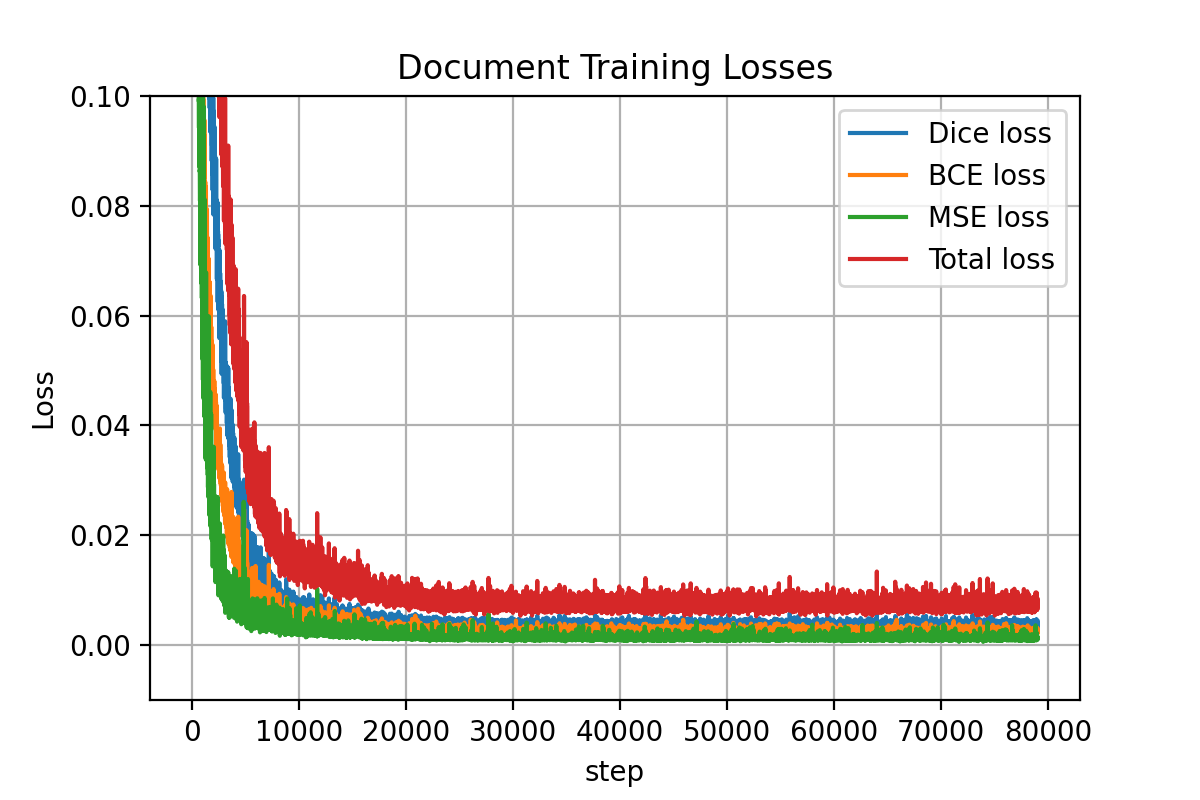

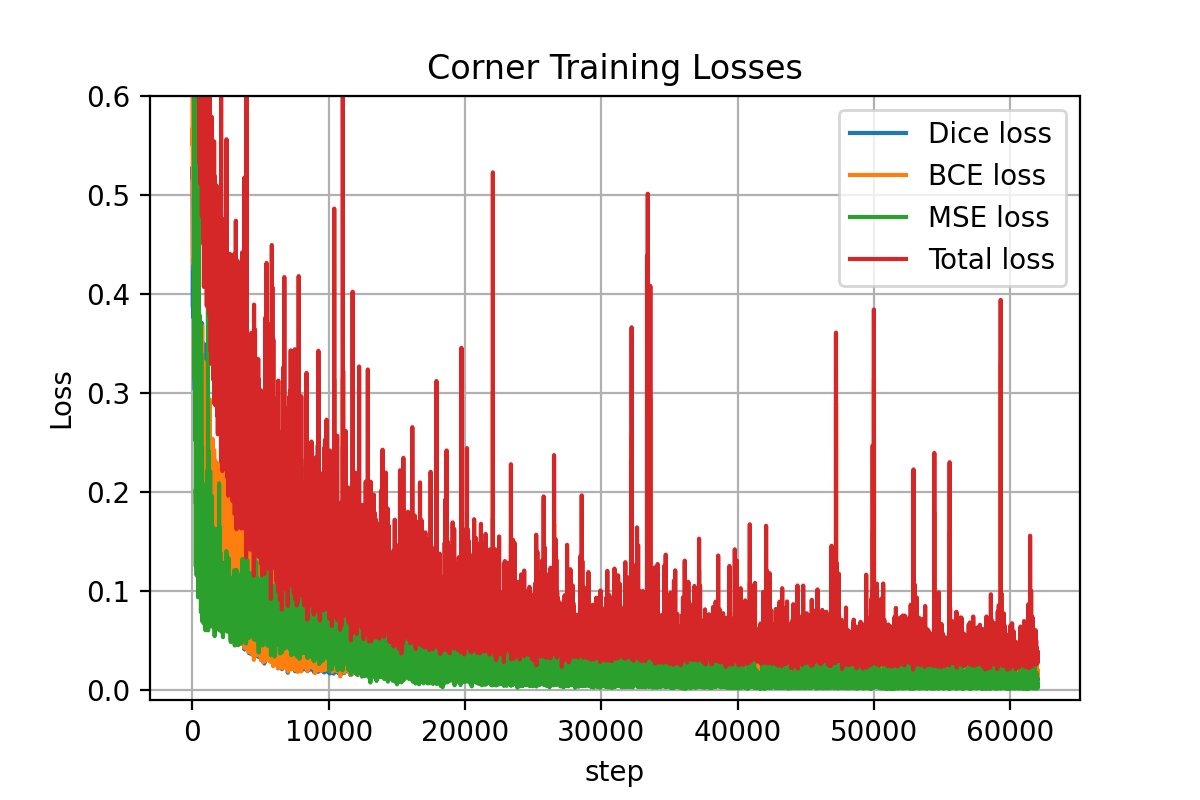

The following are the mean dice score over the test set per background:
*   Background01 Average Dice Score - 0.96250432 
*   Background02 Average Dice Score - 0.97926545 
*   Background03 Average Dice Score - 0.97450084
*   Background04 Average Dice Score -  0.96154397 
*   Background05 Average Dice Score - 0.94764985 

#### Box Plot of Dice Score per Background
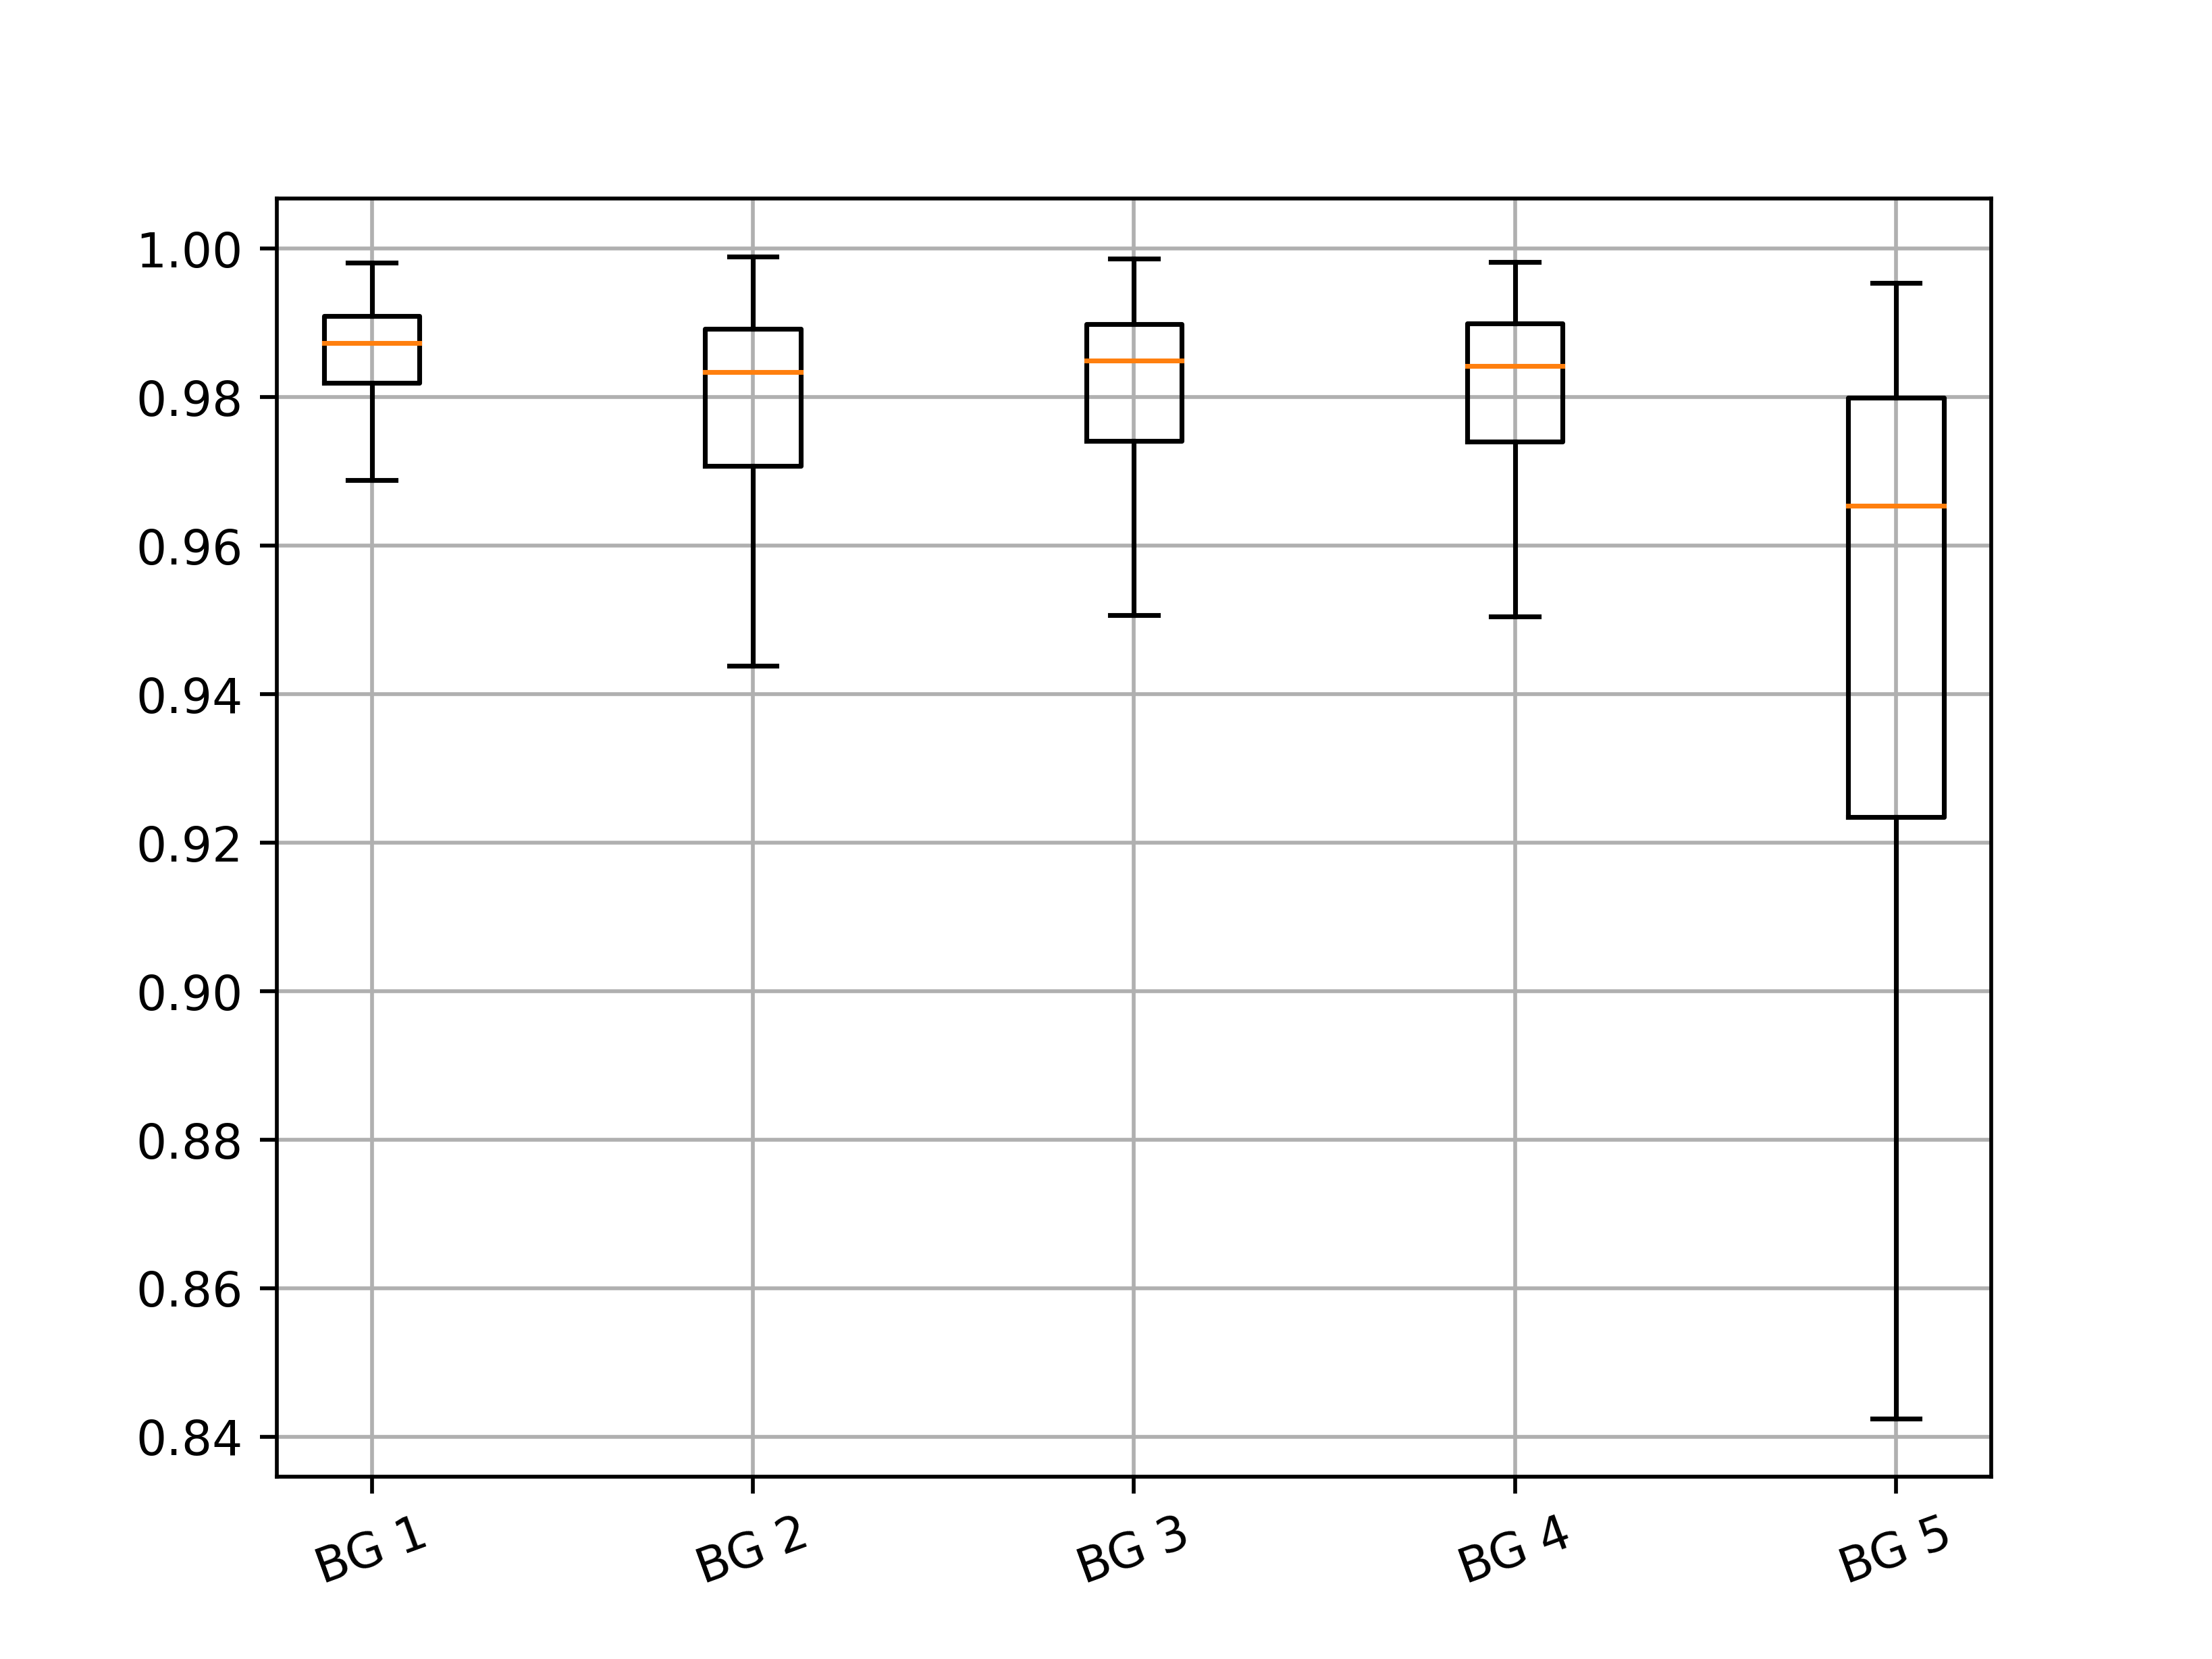

### Results Visuallization
In the following images we samples a random image from each background and plotted the initial corner estimation together with the refined corner estimation

### Background 01
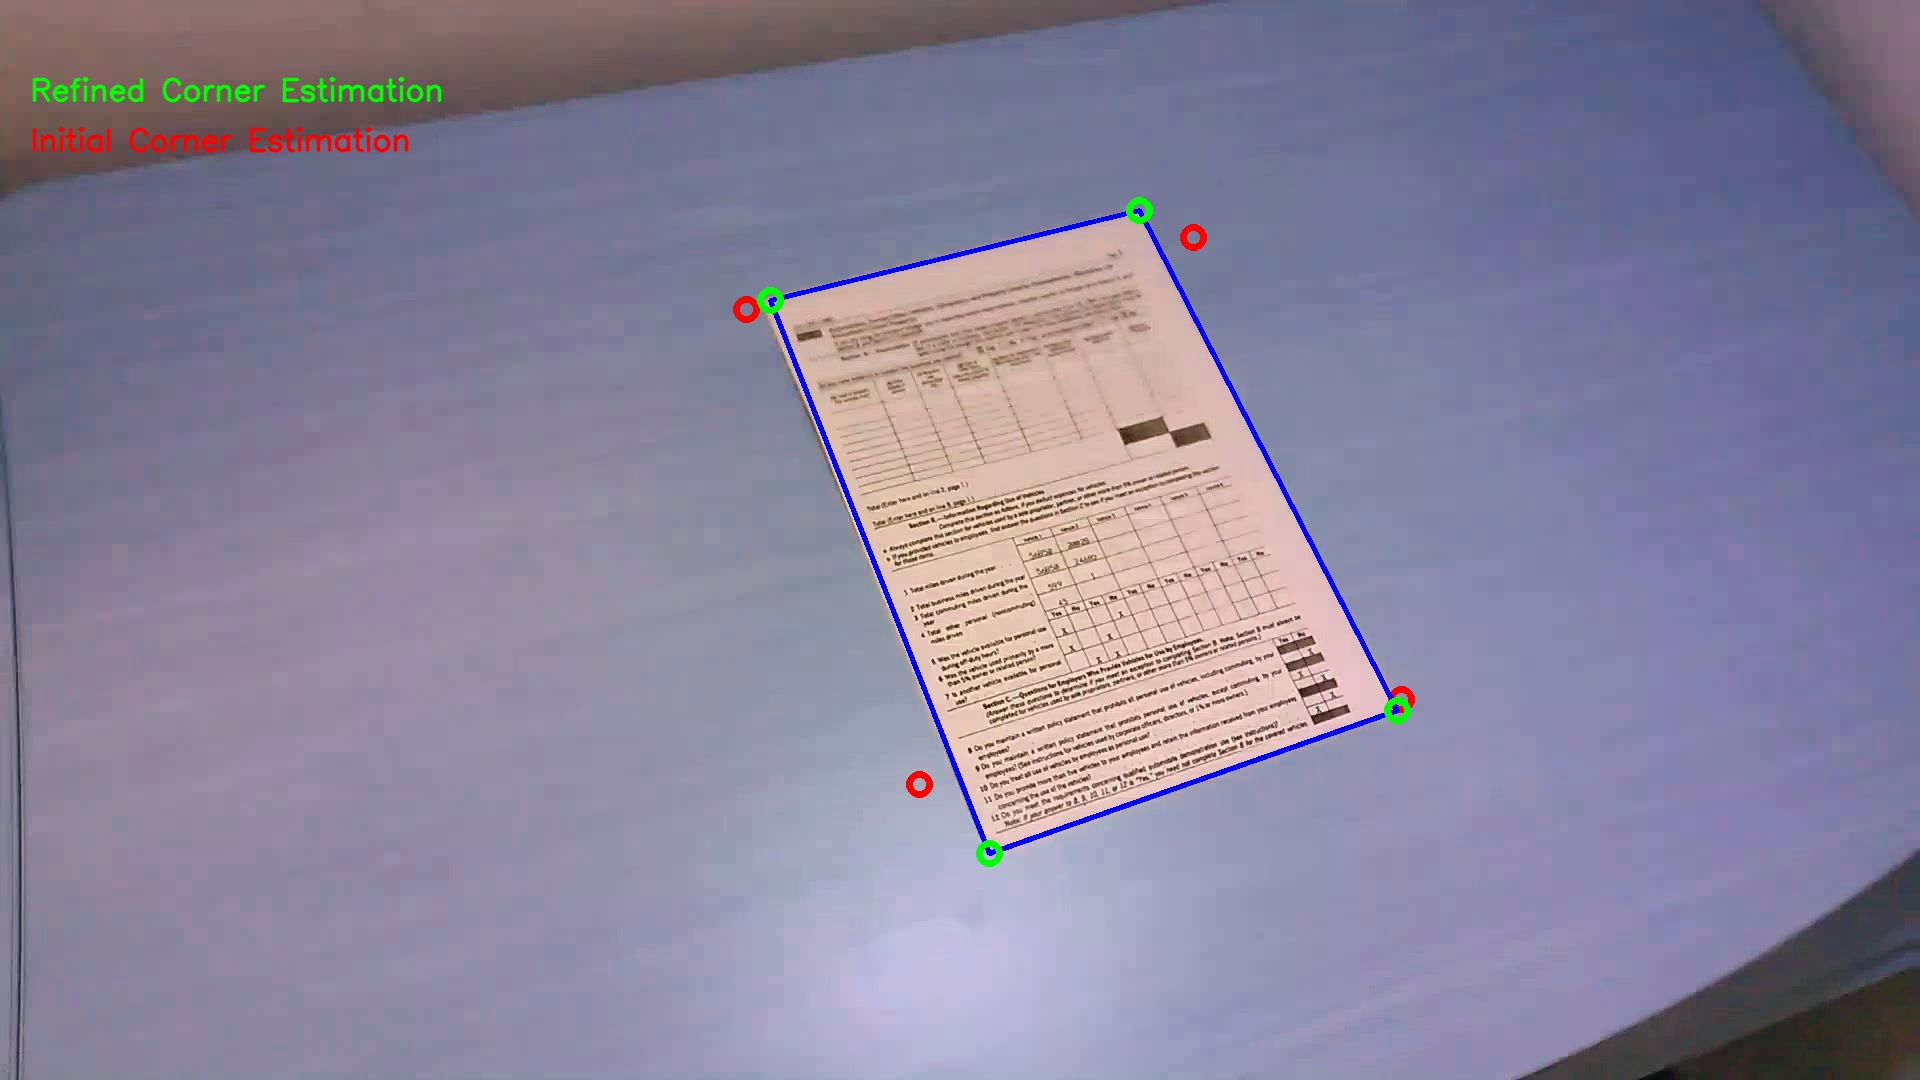

###Background 02
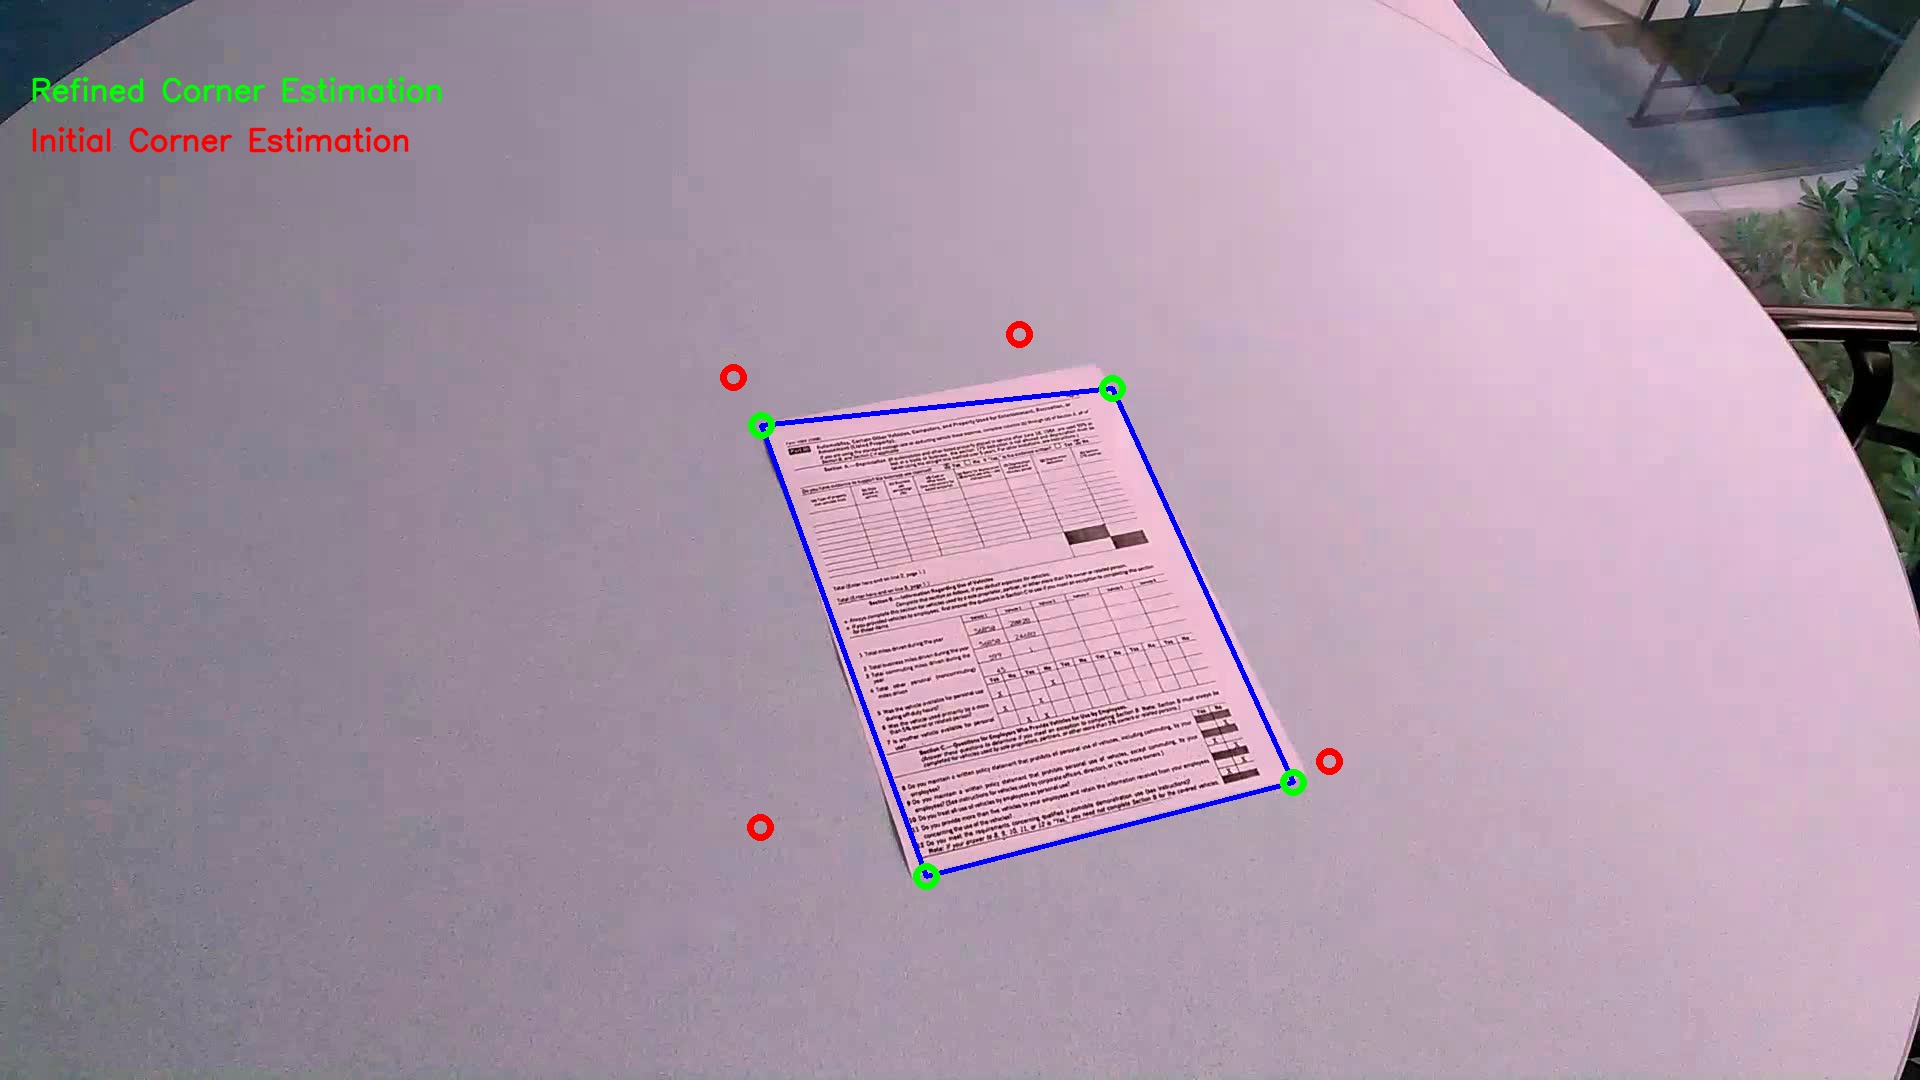

### Background 03
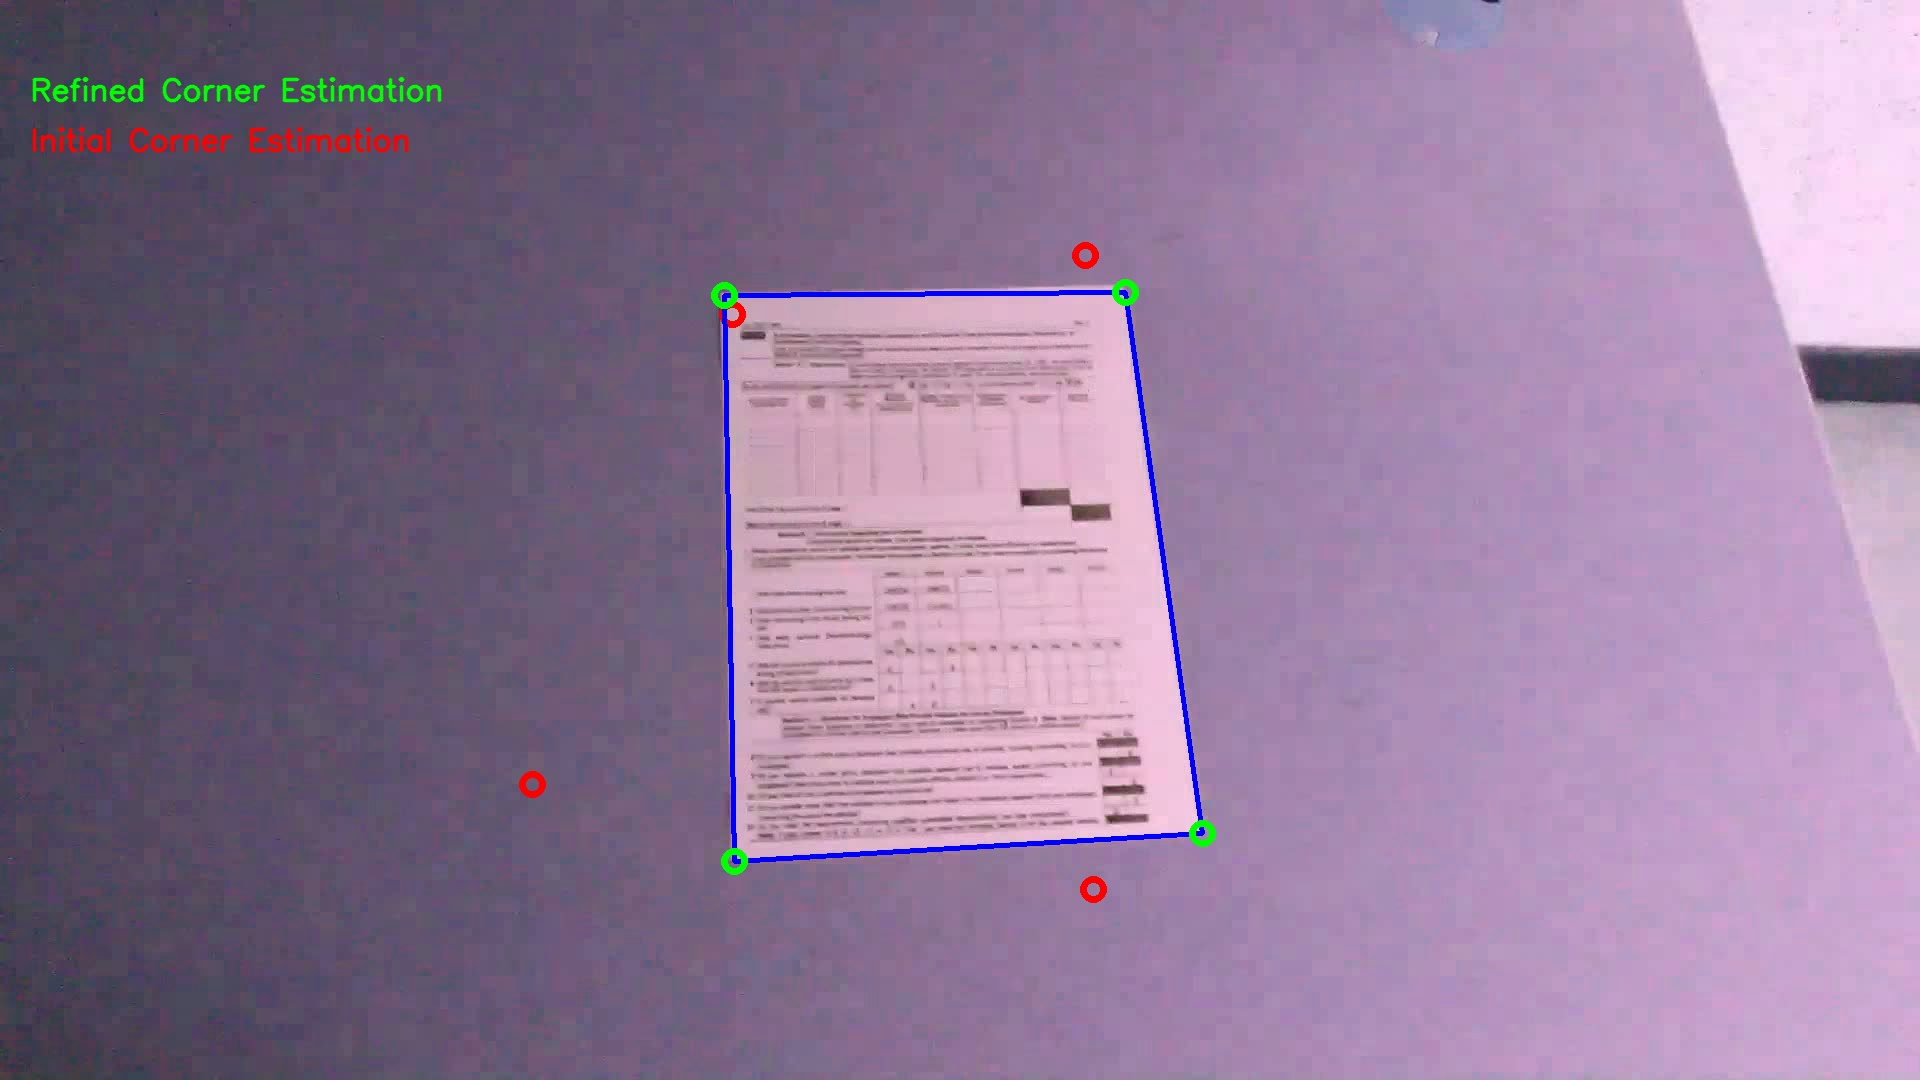

### Background 04
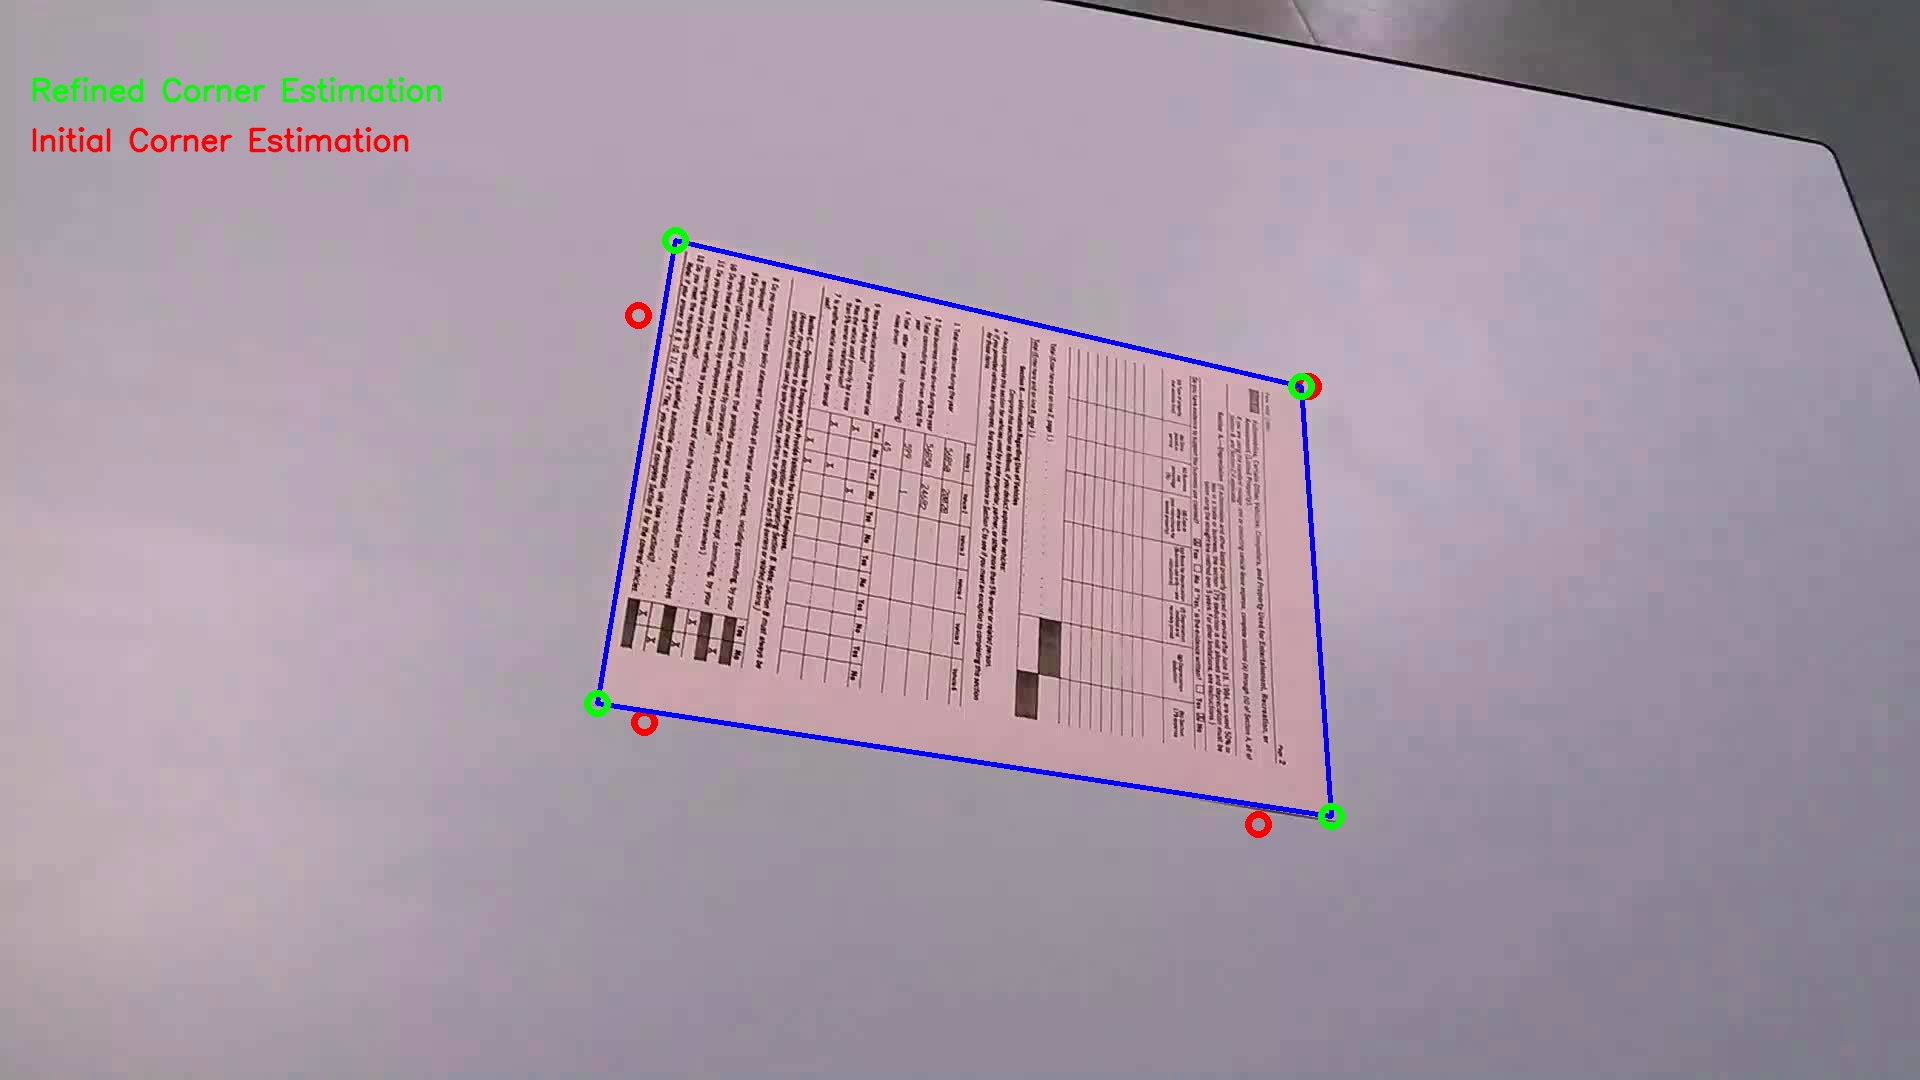

### Background 05
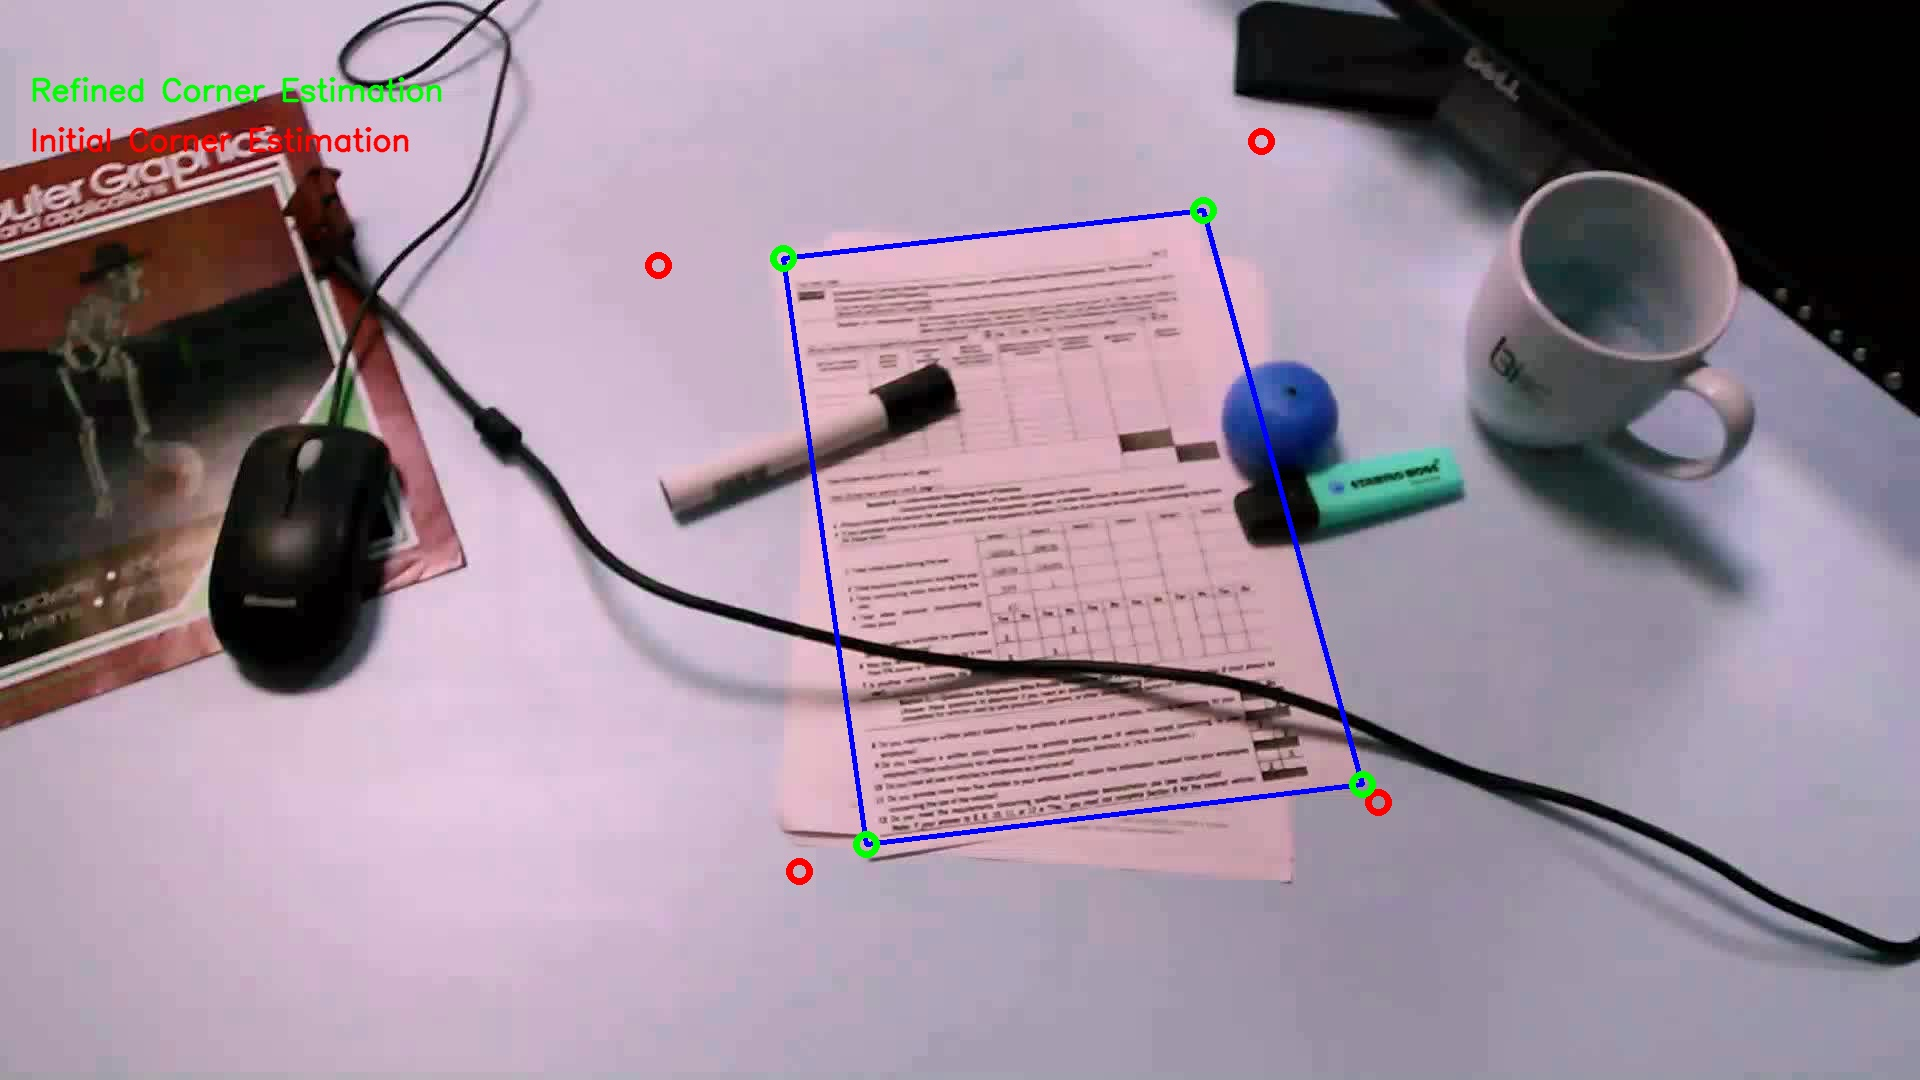

If you want to check some other images just modify the "path" variable

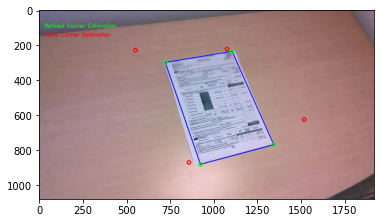

In [53]:
path = "/content/drive/MyDrive/DeepLearningProject/data/Test/background01/tax004.avi/004.jpg"
plt.imshow(visualize_image(path))

## Algorithm 2 Results Analysis:

Unfortunately, this algorithm also did not beat the SOTA benchmark but we have learned a lot from it.

1. One of the advantages of this algorithm and the benchmark algorithm is that before the training the images are resized to 64X64 and labels normalized to [0,1]. This allows the network to train fast over a large data set and to rescale the predicted labels according to the original image size.
2.   The idea behind this algorithm is to use the masked image to assist the CNN ResNet network to "focus" on the relevant pixels in the image.
3.   The idea is to concatenate the UNet and the ResNet and train them as a single network to let gradients from the ResNet network flow back through the UNet together with the gradients from the Combo loss.
4. We think that our results are not better than the benchmark algorithm because the network is very deep hence gradients from the ResNet20 can vanish at the UNet.
5. Surpassing the SOTA results is quite challenging in this problem because as reported in the benchmark section, the results of the benchmark are almost optimal (dice score near 1).



# Conclusions
1. We learned that following our natural human intuition about what will cause performance improvement may not introduce any improvement at all, as we've faced in our proposed V2 algorithm.
2. From the proposed V1 algorithm we conclude that a combination of classical image processing algorithms and deep learning algorithms may achieve a powerful algorithm.
3. Comparing our two proposals, we conclude that a fully data-driven model may sometimes outperform a "hybrid" algorithm, i.e., a solution derived from both data-driven and model-driven methods.
4. As part of our attempts to reduce train complexity, we trained the UNet over small images, and in the inference step, we have used larger images. The high precision details combined with a large image induce further noise to our segmentation task, which leads to a failure.
5. We shall mention that we have also tried to use a simple fully connected network as part of our initial attempts to solve this problem. Unfortunately, these attempts failed miserably. From this, we conclude that simply using a neural network doesn't take full advantage of the natural image's structure.
6. As part of the hyperparameter tuning phase, we've found out that our algorithms were with low sensitivity to the hyper-parameters of our system.





# References


[1] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.‏

[2] Richard O. Duda and Peter E. Hart. 1972. Use of the Hough transformation to detect lines and curves in pictures. Commun. ACM 15, 1 (Jan. 1972), 11–15. 

[3] Taghanaki, Saeid Asgari, et al. "Combo loss: Handling input and output imbalance in multi-organ segmentation." Computerized Medical Imaging and Graphics 75 (2019): 24-33.

[4] Forgy, Edward W. (1965). "Cluster analysis of multivariate data: efficiency versus interpretability of classifications". Biometrics. 21 (3): 768–769.

[5] Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis". Computational and Applied Mathematics. 20: 53–65

[6] K. Javed and F. Shafait, "Real-Time Document Localization in Natural Images by Recursive Application of a CNN," 2017 14th IAPR International Conference on Document Analysis and Recognition (ICDAR), 2017, pp. 105-110

[7] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.‏


